# CAPSTONE PROJECT
# Title: IN VEHICLE COUPON RECOMMENDATION SYSTEM

### GROUP TWARB

### MEMBERS: 
1. Austin Kanja
2. Benson Ouma
3. Rahab Gachie
4. Ted Ronoh 
5. Winnie Odoyo


## Business Understanding

In today’s competitive marketing environment, businesses need to deliver the right promotional coupons to the right customers at the right time to maximize engagement and conversion. This project aims to build a recommendation system that suggests the most suitable coupon for each individual based on a combination of inputs; including their demographics, current context (such as weather, time of day and destination) and past behavioral patterns. By leveraging these factors, the system can personalize coupon offers, improve acceptance rates and enhance customer satisfaction while optimizing the organization’s promotional efforts.

## Problem Statement
In the competitive food and beverage industry, businesses frequently use coupons to attract customers. However, sending irrelevant or poorly timed coupons often results in low redemption rates, wasted marketing resources, and customer disengagement. At the same time, customers value offers that are timely, relevant, and tailored to their preferences and current situation. Currently, businesses lack a data-driven system to determine which specific coupon type and expiration period should be offered to maximize the likelihood of acceptance.

**Objective**:
To develop a predictive model that leverages passenger demographics, trip context (time, weather, destination, etc.), and behavioral patterns to recommend the most appropriate coupon type and expiration period for a given passenger during their journey.The model aims to recommend the most appropriate coupon-expiration combination for each passenger based on their demographics, context and behavior, with the goal of maximizing acceptance rates and improving customer satisfaction and campaign efficiency.

## Data Understanding
The data set has been sourced from UC Irvine Machine Learning Repository https://archive.ics.uci.edu/datasets/
The dataset contains 12,684 records and 26 features, including:
- Demographic information: gender, age, marital Status, education, income
- Contextual data: weather, temperature, time, destination, passanger
- Behavioral indicators: frequency of visiting Bar, Coffee-house, Restaurant Less Than 20, etc.
- Target variable(Y): Coupon and expiration

### Loading the Data
Importing the libraries that will be used through out the project.


In [101]:
import pandas as pd   
import numpy as np  
import zipfile
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import make_pipeline 
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


In [5]:
# extract the files
zip_path = 'in+vehicle+coupon+recommendation.zip'

extract_dir = 'unzipped/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    
    zip_ref.extractall(extract_dir)
    print(f"Files extracted to {extract_dir}")
    
    print("Files in the zip archive:")
    for file in zip_ref.namelist():
        print(file)

Files extracted to unzipped/
Files in the zip archive:
in-vehicle-coupon-recommendation.csv


In [6]:
# Load the dataset
df = pd.read_csv('unzipped\in-vehicle-coupon-recommendation.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


### EXPLORATORY DATA ANALYSIS- EDA
#### 1. Data Cleaning

#### 1.0 Check for missing values

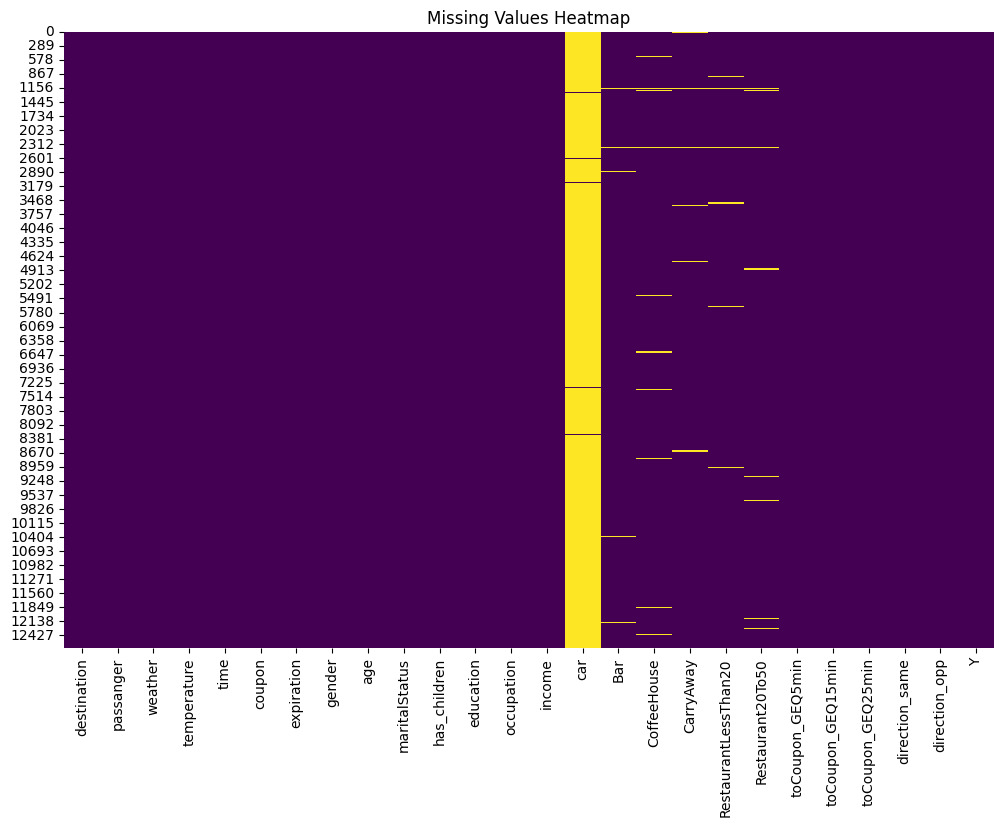

In [7]:
# check for missing values
df.isnull().sum()

# visualize the missing values
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

From the above visualization, the car column has excessive missing values (99%). The ideal way of handling this is by dropping the column.


#### 1.1 Handling Missing Values

In [8]:
# drop car column
df_cleaned = df.drop(columns=['car'])

# For categorical columns with few missing values we fill with mode
cat_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in cat_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# For numerical columns we fill with median
num_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Check if any missing values remain
print(df_cleaned.isnull().sum().sum())

0


In [9]:
print(num_cols)
print(cat_cols)

Index(['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min',
       'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y'],
      dtype='object')
Index(['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income',
       'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20',
       'Restaurant20To50'],
      dtype='object')


#### 1.2 Check for duplicate rows

In [10]:
# Checking for duplicated rows
print(f"Number of duplicate rows: {df_cleaned.duplicated().sum()}")

Number of duplicate rows: 74


In [11]:
# remove the duplicate rows
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates()
duplicates_removed = initial_rows - len(df_cleaned)
print(f"✓ Removed {duplicates_removed} duplicate rows")


✓ Removed 74 duplicate rows


Correct the typo in 'passanger' to 'passenger'

In [12]:
df_cleaned = df_cleaned.rename(columns={'passanger': 'passenger'})
print("✓ Fixed column name: 'passanger' → 'passenger'")

✓ Fixed column name: 'passanger' → 'passenger'


In [13]:
# Standardize age column (convert to consistent format)
print("\
Standardizing age column:")
print("-" * 25)
print("Original age values:", df_cleaned['age'].unique())

# Create age mapping
age_mapping = {
    'below21': '18-20',
    '21': '21-25', 
    '26': '26-30',
    '31': '31-35',
    '36': '36-40',
    '41': '41-45',
    '46': '46-50',
    '50plus': '50+'
}

df_cleaned['age_group'] = df_cleaned['age'].map(age_mapping)
print("New age groups:", df_cleaned['age_group'].unique())
print("✓ Created standardized age_group column")

print(f"\
Current dataset shape: {df_cleaned.shape}")
print(f"Remaining missing values: {df_cleaned.isnull().sum().sum()}")

Standardizing age column:
-------------------------
Original age values: ['21' '46' '26' '31' '41' '50plus' '36' 'below21']
New age groups: ['21-25' '46-50' '26-30' '31-35' '41-45' '50+' '36-40' '18-20']
✓ Created standardized age_group column
Current dataset shape: (12610, 26)
Remaining missing values: 0


#### 1.3 Checking for outliers in the columns

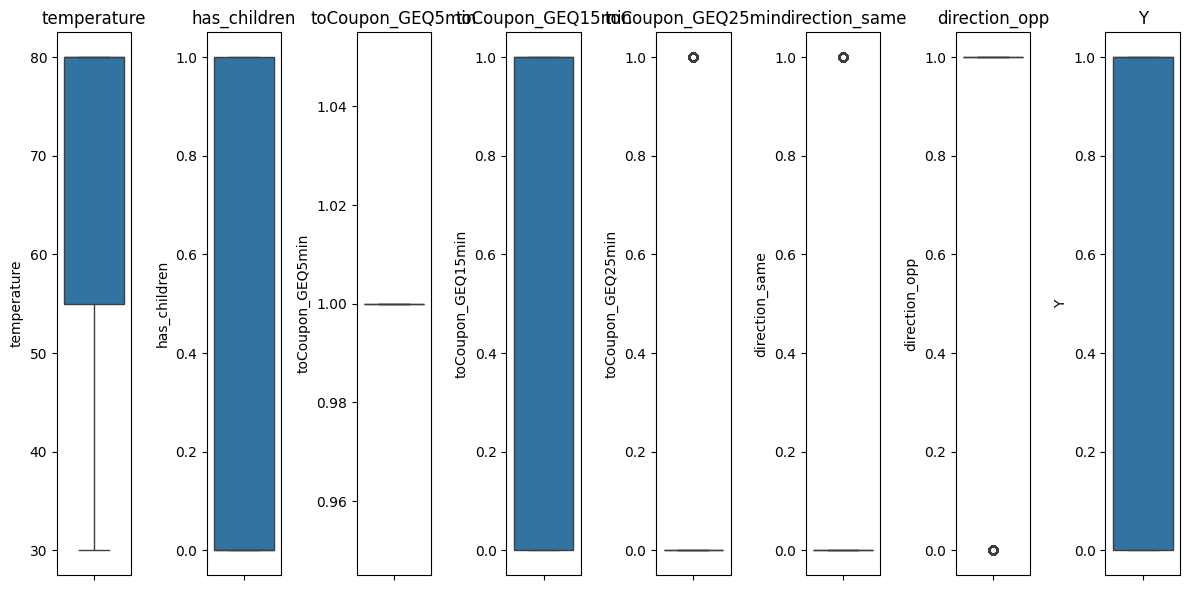

Outliers in temperature: 0
Outliers in has_children: 0
Outliers in toCoupon_GEQ5min: 0
Outliers in toCoupon_GEQ15min: 0
Outliers in toCoupon_GEQ25min: 1463
Outliers in direction_same: 2718
Outliers in direction_opp: 2718
Outliers in Y: 0


In [14]:
# Boxplots for numerical variables
plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df_cleaned[col])
    plt.title(col)
plt.tight_layout()
plt.show()

# Statistical outlier detection
for col in num_cols:
    q1 = df_cleaned[col].quantile(0.25)
    q3 = df_cleaned[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    print(f"Outliers in {col}: {len(outliers)}")

#### 1.4 Checking for unusual categories in categorical variables
Checking for unusual categories ensures:
* Data quality- to catch typos or inconsistent labels.
* Model readiness- find rare categories that could hurt performance.
* Better features- decide if rare categories should be grouped or dropped.
* Understand distribution- see if the feature is balanced or dominated by one class.

In [15]:
# Check for unusual/rare categories in categorical variables
for col in cat_cols:
    value_counts = df_cleaned['passenger'].value_counts(normalize=True)
    
    print(f"\nValue counts for {col}:")
    print(value_counts)
    
    # Identify rare categories (<1% of data)
    rare_categories = value_counts[value_counts < 0.01].index
    
    if len(rare_categories) > 0:
        print(f"Rare categories in {col}: {list(rare_categories)}")



Value counts for destination:
passenger
Alone        0.574782
Friend(s)    0.261063
Partner      0.084774
Kid(s)       0.079381
Name: proportion, dtype: float64

Value counts for passanger:
passenger
Alone        0.574782
Friend(s)    0.261063
Partner      0.084774
Kid(s)       0.079381
Name: proportion, dtype: float64

Value counts for weather:
passenger
Alone        0.574782
Friend(s)    0.261063
Partner      0.084774
Kid(s)       0.079381
Name: proportion, dtype: float64

Value counts for time:
passenger
Alone        0.574782
Friend(s)    0.261063
Partner      0.084774
Kid(s)       0.079381
Name: proportion, dtype: float64

Value counts for coupon:
passenger
Alone        0.574782
Friend(s)    0.261063
Partner      0.084774
Kid(s)       0.079381
Name: proportion, dtype: float64

Value counts for expiration:
passenger
Alone        0.574782
Friend(s)    0.261063
Partner      0.084774
Kid(s)       0.079381
Name: proportion, dtype: float64

Value counts for gender:
passenger
Alone      

#### 1.5 Examining unique values for the categorical columns
The purpose of this is to  understand the possible categories each variable can take, detect unexpected or inconsistent entries and identify rare or dominant categories.

In [16]:
# Examine unique values in categorical columns
categorical_cols = ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration', 
                   'gender', 'age', 'maritalStatus', 'has_children', 'education', 'occupation', 
                   'income', 'car']

print("Unique values in categorical columns:")
for col in categorical_cols:
    if col in df_cleaned.columns:
        unique_vals = df_cleaned[col].unique()
        print(f"\
{col} ({len(unique_vals)} unique values):")
        print(unique_vals)

Unique values in categorical columns:
destination (3 unique values):
['No Urgent Place' 'Home' 'Work']
weather (3 unique values):
['Sunny' 'Rainy' 'Snowy']
time (5 unique values):
['2PM' '10AM' '6PM' '7AM' '10PM']
coupon (5 unique values):
['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
expiration (2 unique values):
['1d' '2h']
gender (2 unique values):
['Female' 'Male']
age (8 unique values):
['21' '46' '26' '31' '41' '50plus' '36' 'below21']
maritalStatus (5 unique values):
['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
has_children (2 unique values):
[1 0]
education (6 unique values):
['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
occupation (25 unique values):
['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related

From the analysis above, we observe that;
* The dataset contains diverse trip contexts, with 3 destinations (No Urgent Place, Home, Work) and 4 passenger types (Alone, Friend(s), Kid(s), Partner).
*  Weather and time have limited but meaningful variation: mostly Sunny, and trips occur across 5 times of day.
* There are 5 distinct coupon types and 2 expiration options (1 day, 2 hours) which is good for modeling but watch for class imbalance.
*  Gender is binary and balanced, and age has 8 groups spanning young to older adults.
*  Marital status and has_children provide family context- useful for personalization.
* Education and income show socioeconomic diversity, with 6 education levels and 9 income brackets.
* Overall: The data captures key demographic, behavioral, and trip context variables, with manageable numbers of categories in each making it suitable for classification, clustering, and recommendation tasks.
* Features like destination, time, weather, passenger, gender, has_children, coupon, and expiration are already clean and manageable.
* Demographics (age, maritalStatus, education, income, occupation) may benefit from grouping to avoid sparse categories and improve model robustness.
* Rare categories can hurt model generalization it's  better to merge them into meaningful, interpretable groups.

### 2. Univariate Exploration

#### 2.0 Target Variable Univariate Exploration
Since we’re predicting coupon & expiration we'll explore the:
1. Frequency counts:
-  How many records per coupon type? 
-  How many per expiration?



Coupon Summary (Frequency & Acceptance Rate):
                  coupon  frequency  acceptance_rate
0                    Bar       2017         0.410015
1  Carry out & Take away       2393         0.735478
2           Coffee House       3996         0.499249
3      Restaurant(20-50)       1492         0.441019
4        Restaurant(<20)       2786         0.707107 

Expiration Summary (Frequency & Acceptance Rate):
  expiration  frequency  acceptance_rate
0         1d       7091         0.625582
1         2h       5593         0.495977 



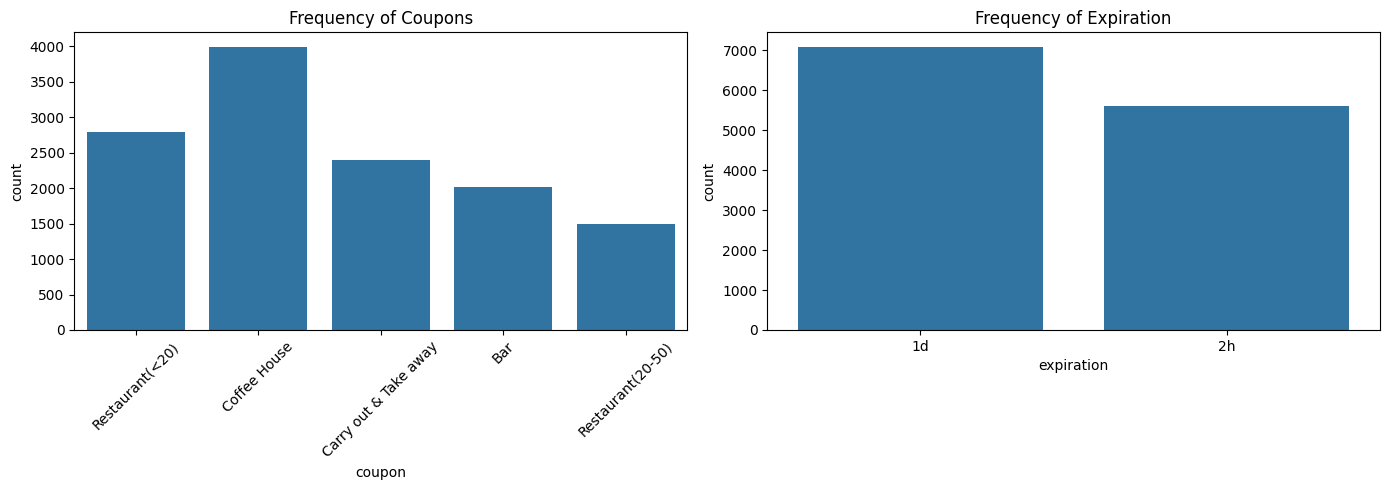

In [17]:
# Frequency + acceptance for coupon
if 'Y' in df.columns:
    coupon_summary = (
        df.groupby('coupon')
        .agg(frequency=('coupon', 'count'), acceptance_rate=('Y', 'mean'))
        .reset_index()
    )
    print("\nCoupon Summary (Frequency & Acceptance Rate):")
    print(coupon_summary, "\n")

    expiration_summary = (
        df.groupby('expiration')
        .agg(frequency=('expiration', 'count'), acceptance_rate=('Y', 'mean'))
        .reset_index()
    )
    print("Expiration Summary (Frequency & Acceptance Rate):")
    print(expiration_summary, "\n")

else:
    # fallback if Y does not exist
    print("Frequency counts per coupon:")
    print(df['coupon'].value_counts(), "\n")

    print("Frequency counts per expiration:")
    print(df['expiration'].value_counts(), "\n")


# Plot frequencies
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x='coupon', data=df, ax=axes[0])
axes[0].set_title('Frequency of Coupons')
axes[0].tick_params(axis='x', rotation=45)

sns.countplot(x='expiration', data=df, ax=axes[1])
axes[1].set_title('Frequency of Expiration')

plt.tight_layout()
plt.show()


Observations from the analysis above;
1.  Coupons:
* Coffee House is the most frequently offered coupon.
* Followed by Restaurant(<20)  and Carry out & Take away.
* Least frequent is Restaurant(20–50), suggesting high-priced offers are less common.

2.  Expiration:
* Most coupons have a 1-day expiration, making it more common and likely more convenient for users.
* Fewer coupons have a 2-hour expiration.

3. Acceptance rates:
* Highest acceptance coupons: Carry out & Take away (74%) and Restaurant(<20) (71%).
* Lowest acceptance coupon: Bar (41%).
4. Best expiration period: 1-day (63%) which is better accepted than 2-hour (50%).

In summary:
* Most common coupon: Coffee House.
* Least common coupon: Restaurant(20–50).
* Most common expiration: 1-day.

**Insight**:  Longer expirations and affordable coupons are more frequently offered and more likely to be accepted.

#### 2.1 Demographics Analysis
Demographic analysis is done to help us  understand customer characteristics and behaviors, revealing patterns that influence preferences and acceptance rates. It enables targeted coupons, personalized offers and data-driven decisions by identifying which segments are most responsive and which need tailored strategies.The relevant demographic data to our analysis is; **Age, Gender,Marital status, income and whether or not the passenger has children.**

#### Distributions of Demographic features

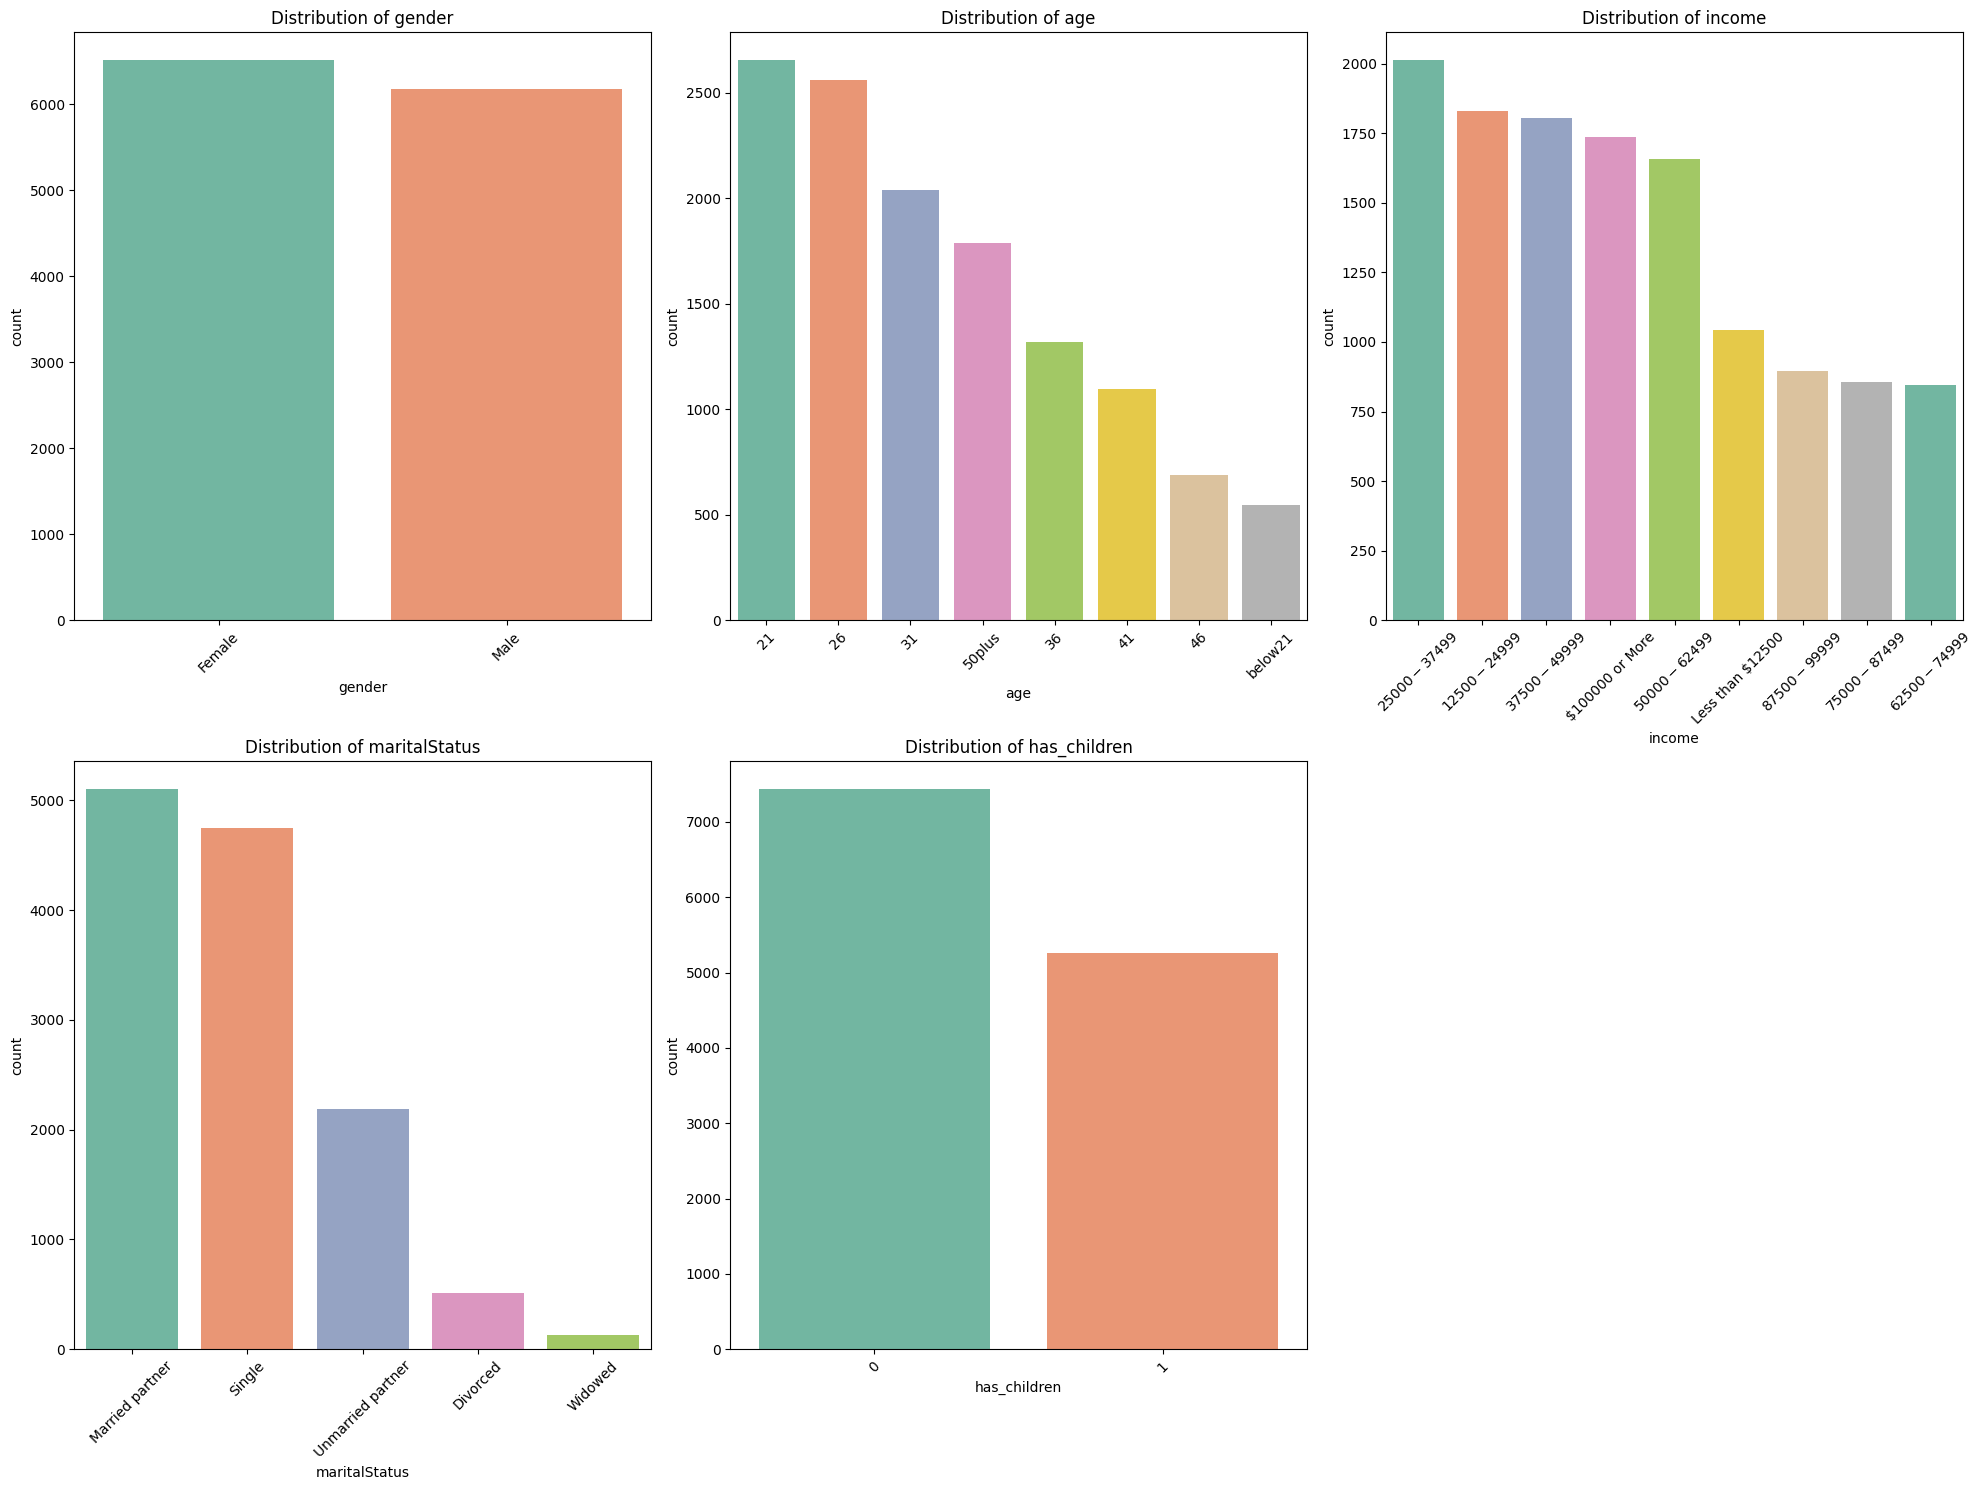

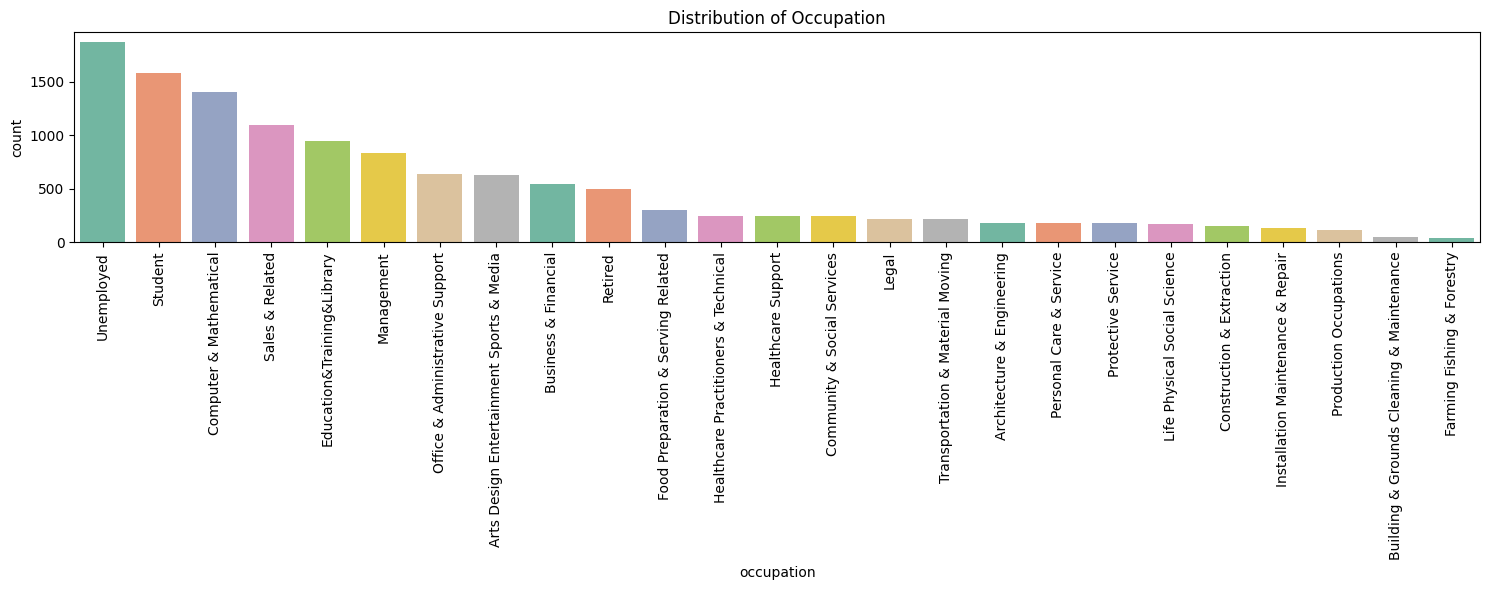

In [18]:
# List
demograph_cols = ['gender', 'age', 'income', 'maritalStatus', 'has_children']

# Subplots 
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(demograph_cols):
    sns.countplot(x=col, data=df, ax=axes[i], palette='Set2', order=df[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused axes
for j in range(len(demograph_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Occupation plot alone
plt.figure(figsize=(15, 6))
sns.countplot(x='occupation', data=df, order=df['occupation'].value_counts().index, palette='Set2')
plt.title('Distribution of Occupation')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#### 2.2 Features vs Targets univariate Exploration
These explorations will help us understand when and under what conditions to recommend specific coupons, which directly informs our recommendation strategy and modelling

In [19]:
# Frequency distributions of categorical predictors
cat_features = ['destination', 'weather', 'time','temperature']

for col in cat_features:
    print(f"\nValue counts of {col}:")
    print(df[col].value_counts())



Value counts of destination:
destination
No Urgent Place    6283
Home               3237
Work               3164
Name: count, dtype: int64

Value counts of weather:
weather
Sunny    10069
Snowy     1405
Rainy     1210
Name: count, dtype: int64

Value counts of time:
time
6PM     3230
7AM     3164
10AM    2275
2PM     2009
10PM    2006
Name: count, dtype: int64

Value counts of temperature:
temperature
80    6528
55    3840
30    2316
Name: count, dtype: int64


**Observations:**
* Destination:
    - Most trips are to No Urgent Place (6,283), followed by Home (3,237) and Work (3,164).
* Weather:
     - Majority of trips happen when it is Sunny (10,069), much fewer when it is Snowy (1,405) or Rainy (1,210).
* Time:
    - Trips are spread fairly evenly, but 6PM (3,230) and 7AM (3,164) are the most common travel times.
* Temperature
    - Most trips occur at 80°F (6,528), fewer at 55°F (3,840) and 30°F (2,316).

**Insights:**
* People tend to travel more for non-urgent reasons, possibly leisure or errands.
* Sunny weather encourages more trips, which is expected as poor weather (rain/snow) likely discourages travel.
* Peak travel times appear to be in the morning (7AM) and evening (6PM), likely aligning with commuting patterns or leisure activities.
*  Warmer temperatures are associated with more trips- possibly more outdoor/social activities.

### 3. Bivariate Exploration

#### 3.0 Target variable Bivariate Exploration
Here we'll explore:
-  The frequency counts of the combination of coupon and expiration
-  Whether some combinations very rare as this could cause imbalance problems

Frequency counts per (coupon + expiration) combination:
                  coupon expiration  count
0                    Bar         1d   1556
1                    Bar         2h    461
2  Carry out & Take away         1d   1456
3  Carry out & Take away         2h    937
4           Coffee House         1d   1769
5           Coffee House         2h   2227
6      Restaurant(20-50)         1d    956
7      Restaurant(20-50)         2h    536
8        Restaurant(<20)         1d   1354
9        Restaurant(<20)         2h   1432 



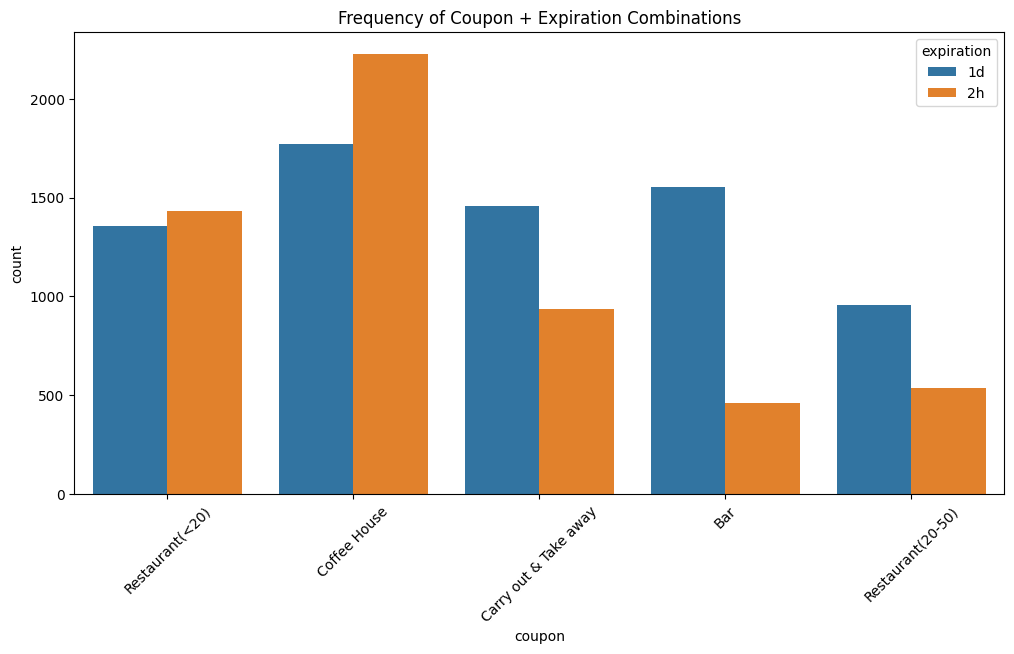

Acceptance rates by coupon + expiration:
                  coupon expiration         Y
0                    Bar         1d  0.411954
1                    Bar         2h  0.403471
2  Carry out & Take away         1d  0.781593
3  Carry out & Take away         2h  0.663821
4           Coffee House         1d  0.583946
5           Coffee House         2h  0.431971
6      Restaurant(20-50)         1d  0.520921
7      Restaurant(20-50)         2h  0.298507
8        Restaurant(<20)         1d  0.831610
9        Restaurant(<20)         2h  0.589385


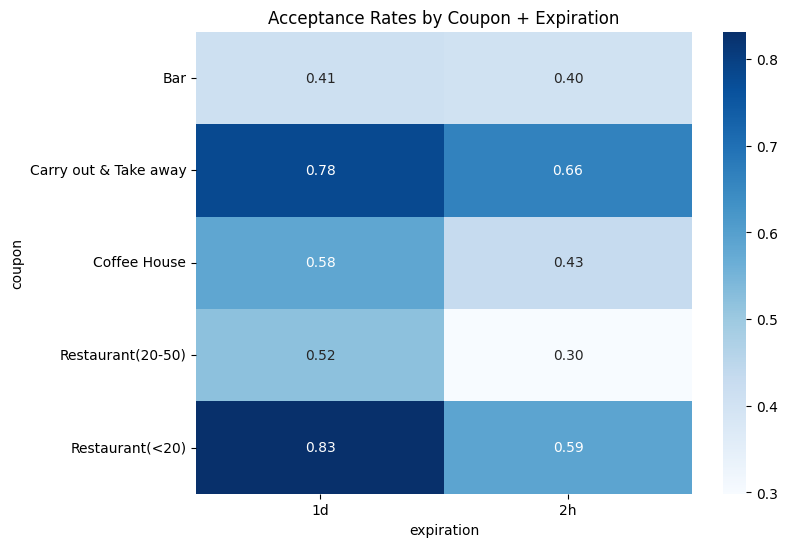

In [20]:
# Frequency counts for coupon + expiration
print("Frequency counts per (coupon + expiration) combination:")
combo_counts = df.groupby(['coupon', 'expiration']).size().reset_index(name='count')
print(combo_counts, "\n")

# Checking for rare combinations (<1% of data)
total = len(df)
rare_combos = combo_counts[combo_counts['count'] / total < 0.01]
if not rare_combos.empty:
    print("Rare coupon+expiration combinations (<1% of data):")
    print(rare_combos)

# Bar plot for coupon + expiration
plt.figure(figsize=(12, 6))
sns.countplot(x='coupon', hue='expiration', data=df)
plt.title('Frequency of Coupon + Expiration Combinations')
plt.xticks(rotation=45)
plt.show()

# With Y acceptance rates
if 'Y' in df.columns:
    print("Acceptance rates by coupon + expiration:")
    acceptance_combo = df.groupby(['coupon', 'expiration'])['Y'].mean().reset_index()
    print(acceptance_combo)

    # heatmap of acceptance rates
    pivot = acceptance_combo.pivot(index='coupon', columns='expiration', values='Y')
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=True, cmap='Blues', fmt=".2f")
    plt.title('Acceptance Rates by Coupon + Expiration')
    plt.show()


Observations from the analysis above:

1. Highest acceptance coupons:
     * Carry out & Take away (74%) and Restaurant(<20) (71%).
2. Lowest acceptance coupon: Bar (41%).
     * Best expiration: 1-day (63%) are better accepted than 2-hour (50%).
3. No combination is rare(<1% of data)

**Insight**: Affordable coupons and longer expiration are more likely to be accepted.

####  3.1 Demographics vs Coupon Preference

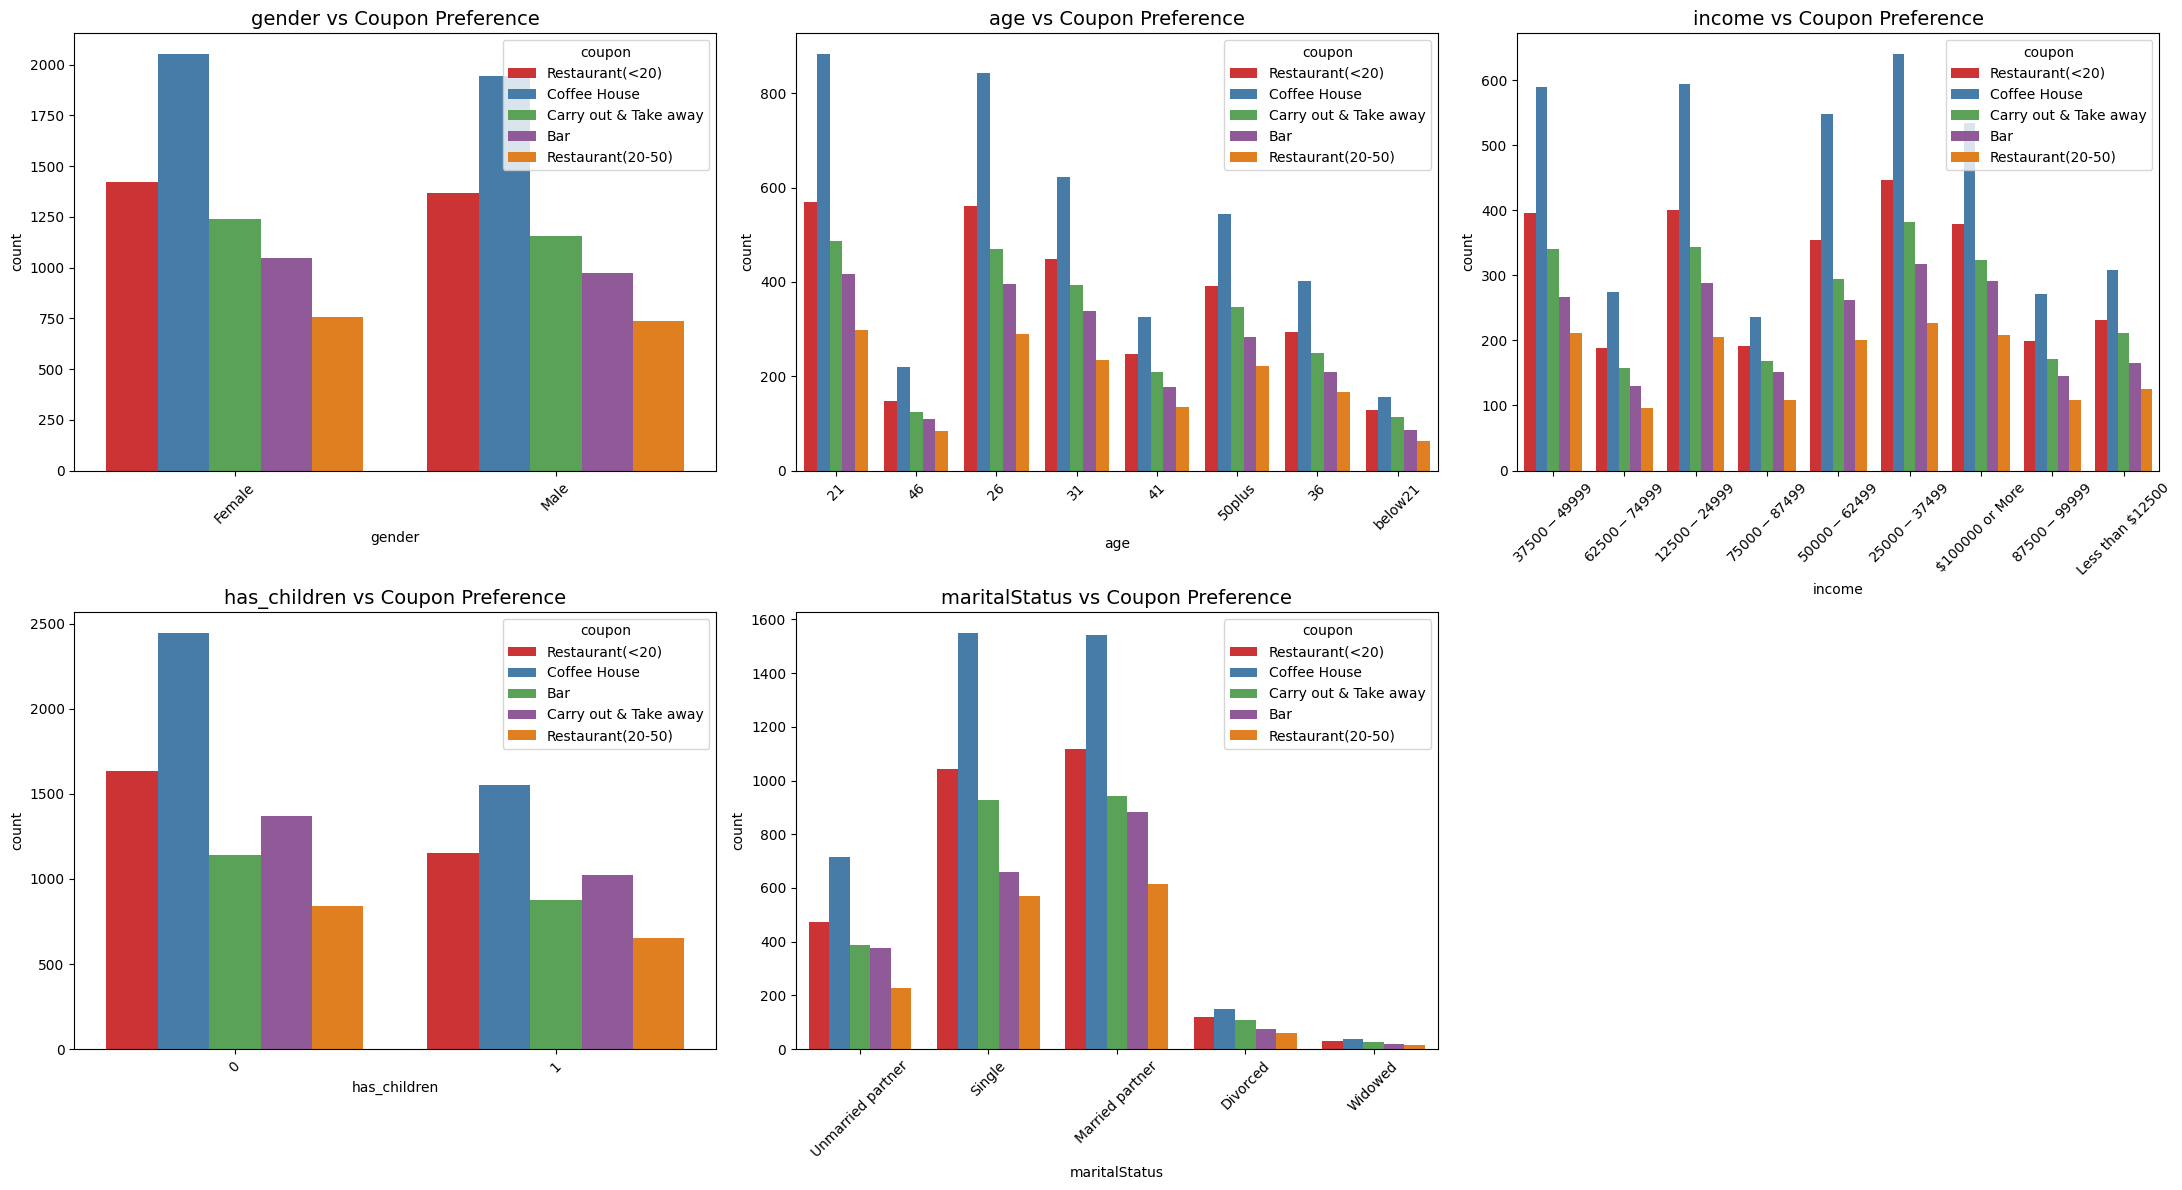

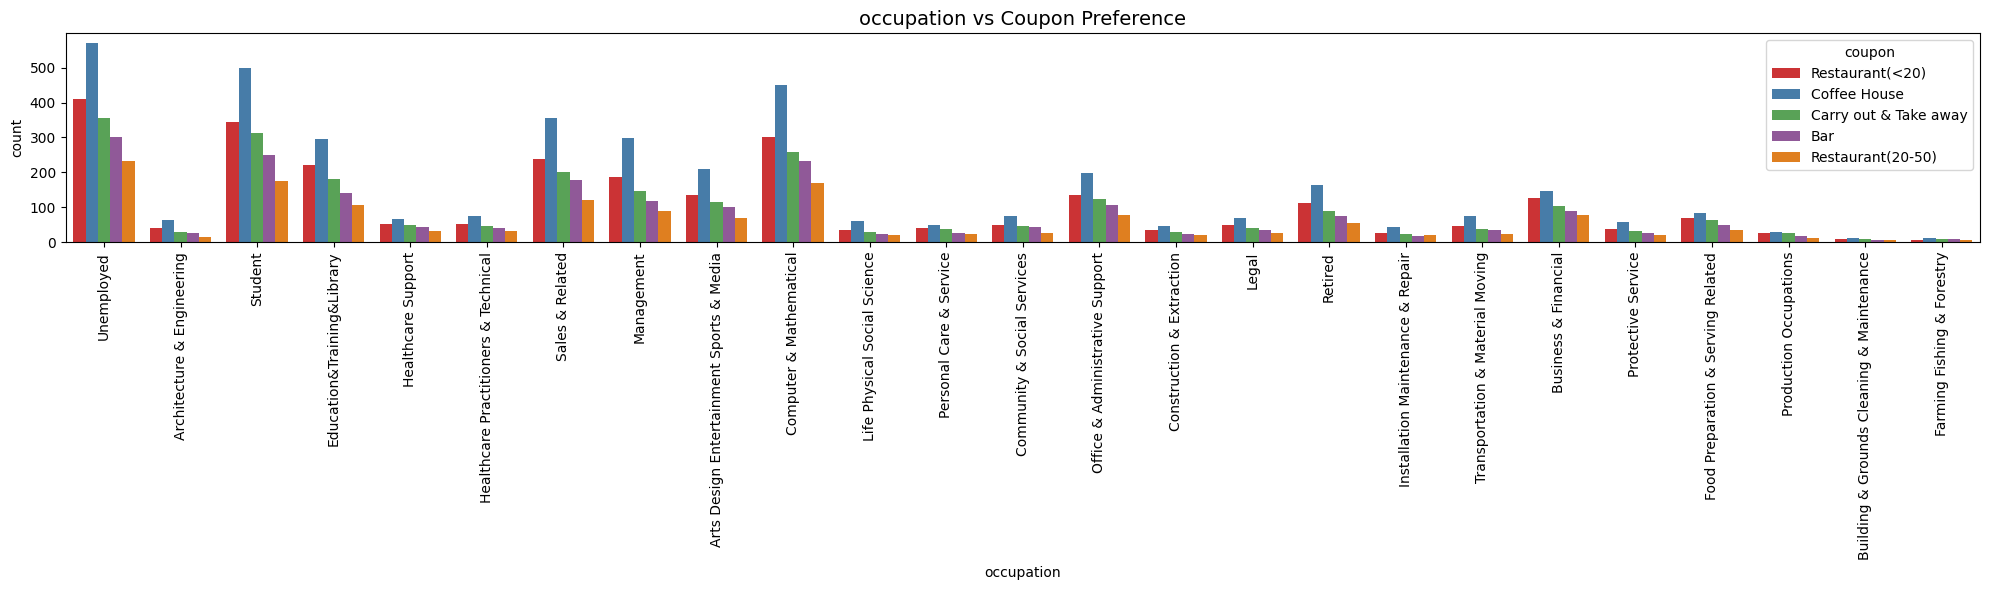

In [21]:
# demographic columns
demograph_cols = ['gender', 'age', 'income', 'has_children', 'maritalStatus']
occupation_col = 'occupation'

# Plot first 5 
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

for i, col in enumerate(demograph_cols):
    sns.countplot(
        x=col, 
        hue='coupon', 
        data=df, 
        ax=axes[i], 
        palette='Set1'
    )
    axes[i].set_title(f'{col} vs Coupon Preference', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

# Hide the last unused subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Plot occupation separately 
plt.figure(figsize=(20, 6))
sns.countplot(
    x=occupation_col, 
    hue='coupon', 
    data=df, 
    palette='Set1'
)
plt.title(f'{occupation_col} vs Coupon Preference', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



#### 3.2 Demographics vs Expiration Preference 

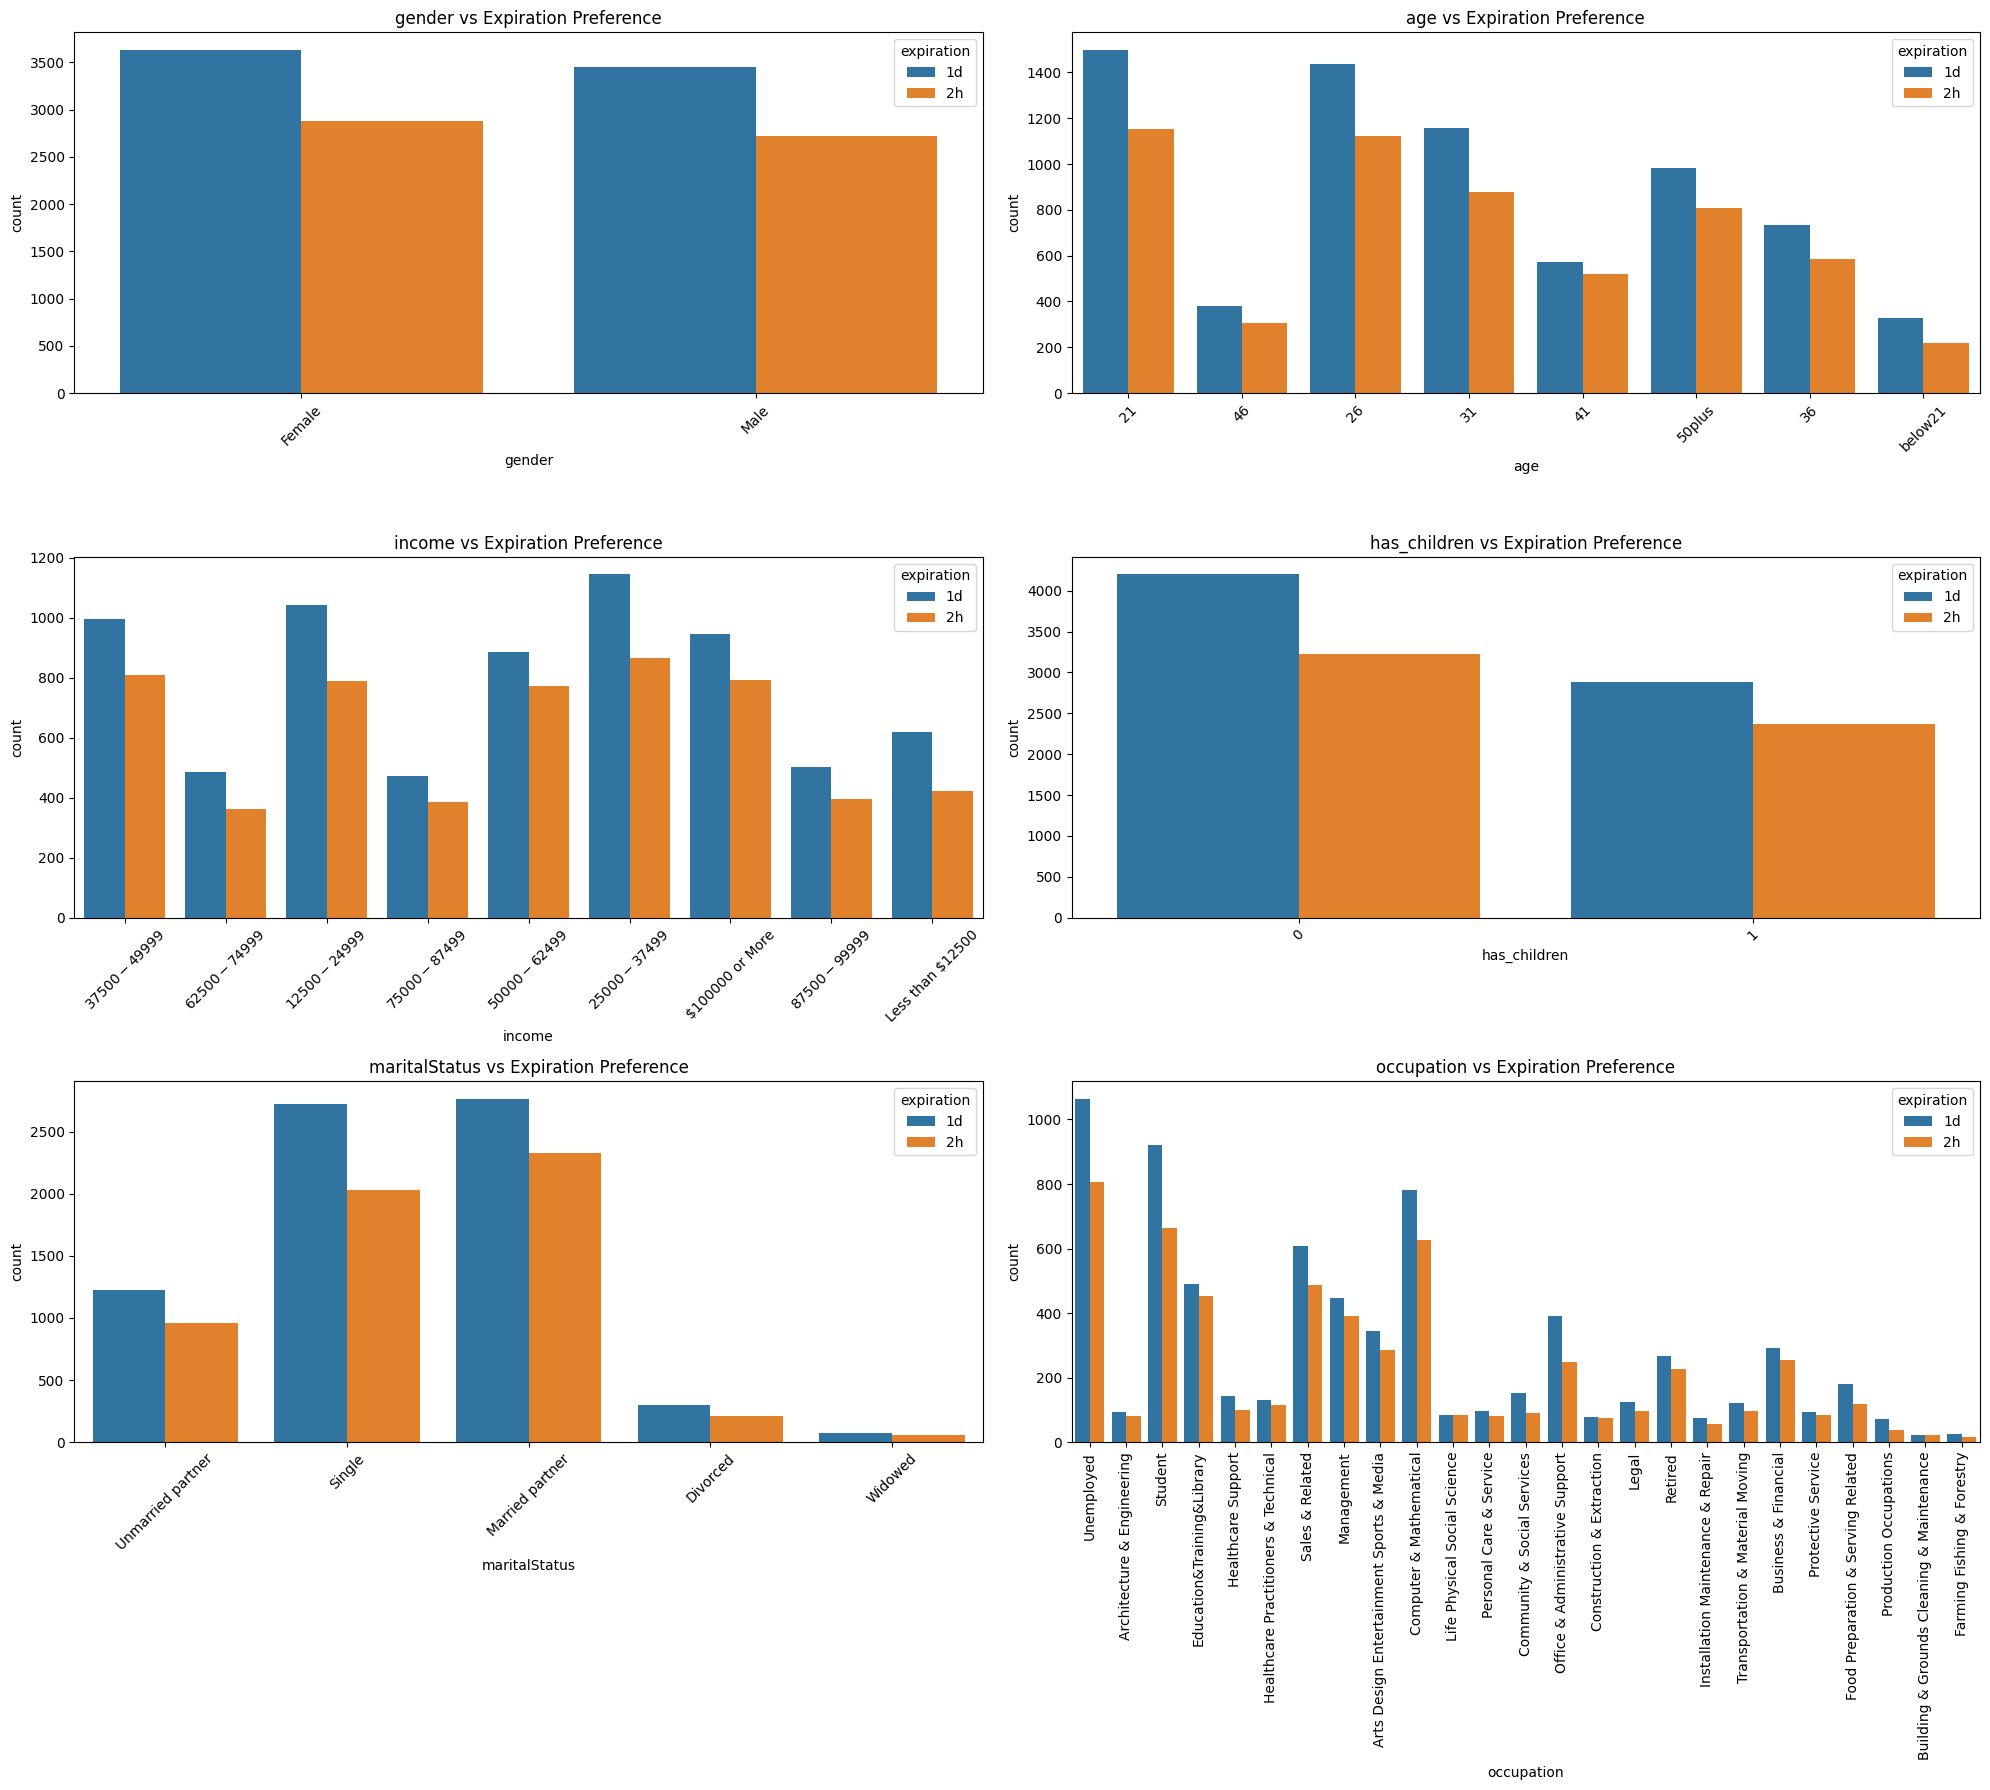

In [22]:
# Create 2x3 grid + 1 separate plot for occupation
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
axes = axes.flatten()

# Plot the 5 demographics
for i, col in enumerate(demograph_cols):
    sns.countplot(x=col, hue='expiration', data=df, ax=axes[i])
    axes[i].set_title(f'{col} vs Expiration Preference')
    axes[i].tick_params(axis='x', rotation=45)

# Plot occupation in the last subplot
sns.countplot(x=occupation_col, hue='expiration', data=df, ax=axes[5])
axes[5].set_title(f'{occupation_col} vs Expiration Preference')
axes[5].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


#### 3.3 Demographics vs Acceptance Rate

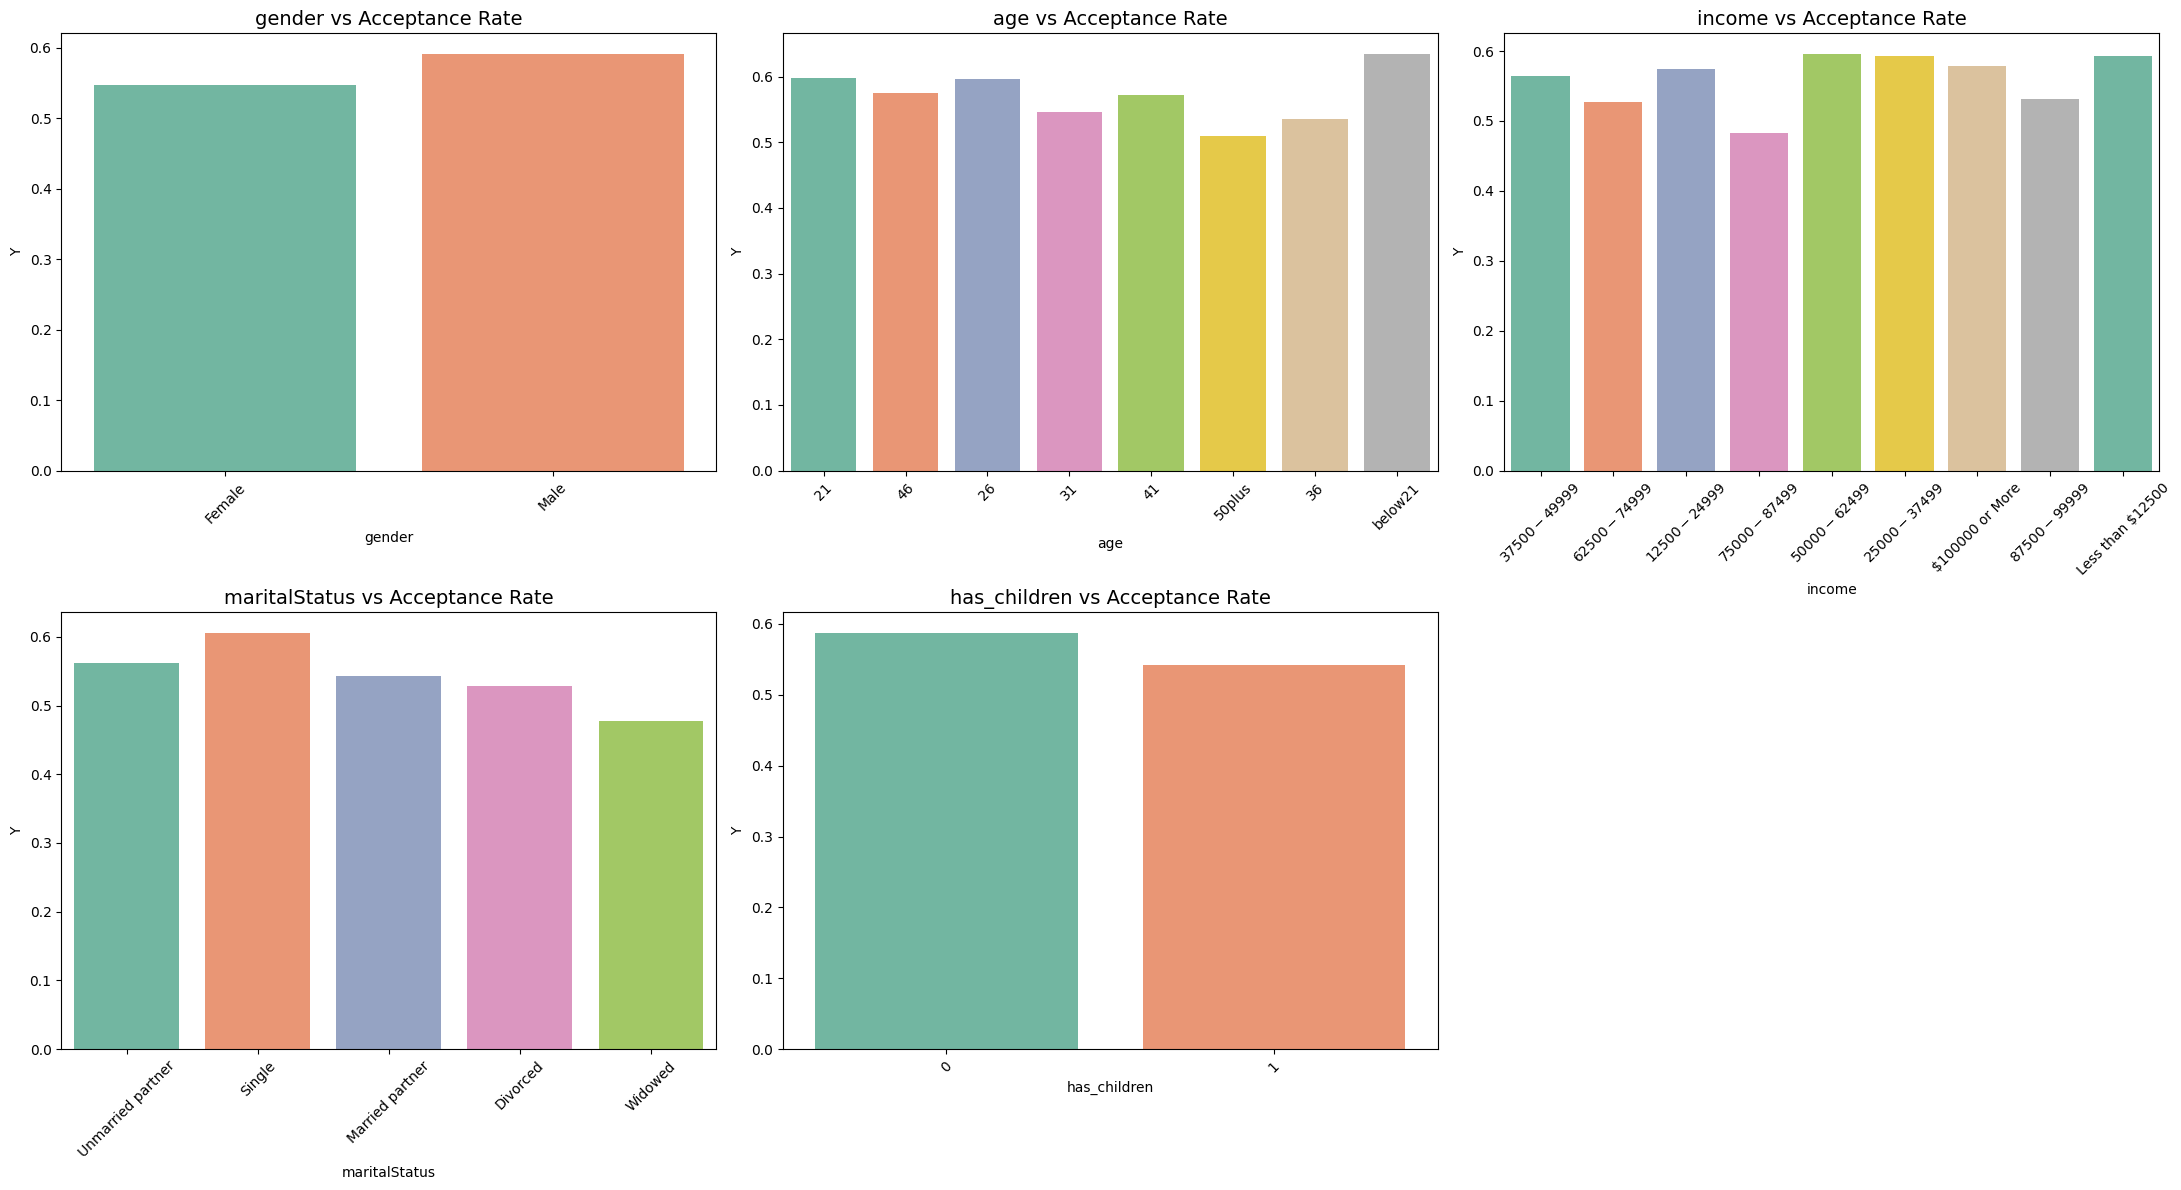

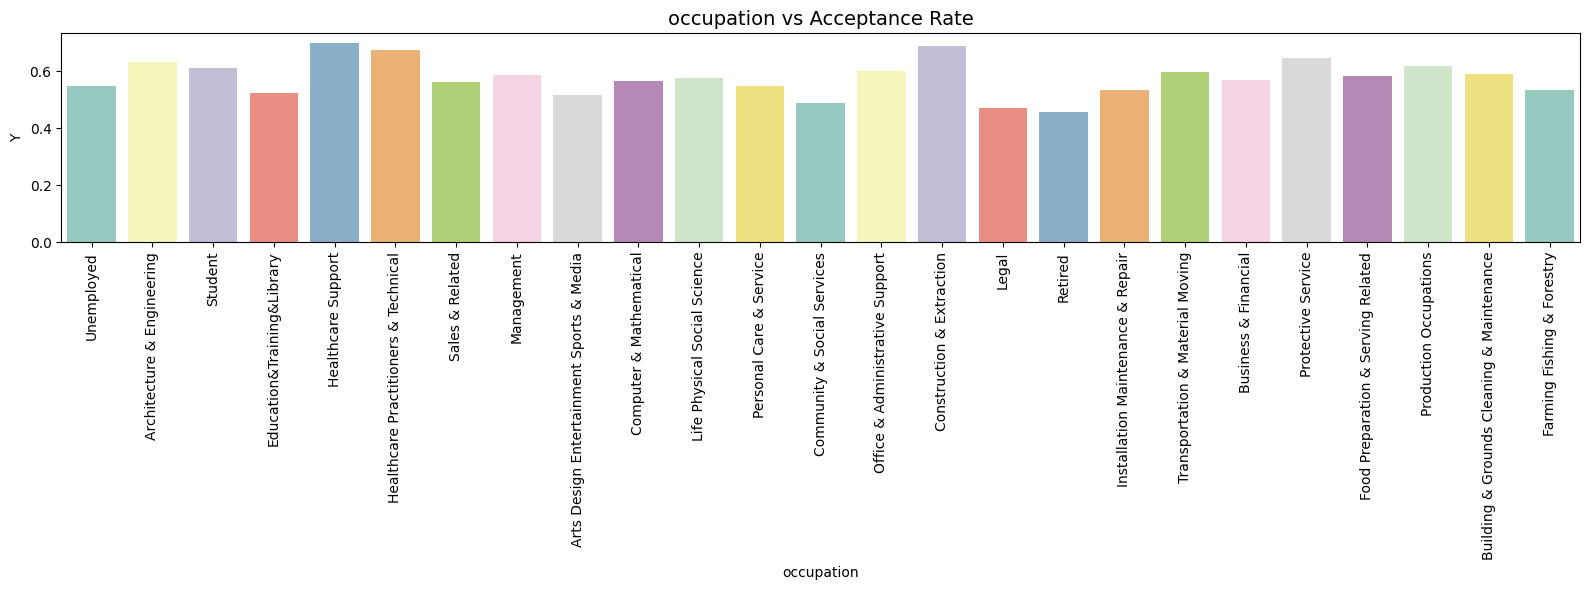

In [23]:
#Demographics columns
demograph_cols = ['gender', 'age', 'income', 'maritalStatus', 'has_children']
occupation_col = 'occupation'

# Subplots 
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

# Loop over demographics,plot acceptance rate
for i, col in enumerate(demograph_cols):
    sns.barplot(
        x=col, y='Y', data=df, ax=axes[i], 
        estimator=np.mean, ci=None, palette='Set2'
    )
    axes[i].set_title(f'{col} vs Acceptance Rate', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

#occupation plot
plt.figure(figsize=(16, 6))
sns.barplot(
    x=occupation_col, y='Y', data=df, 
    estimator=np.mean, ci=None, palette='Set3'
)
plt.title(f'{occupation_col} vs Acceptance Rate', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()




**Observations**
1. Distributions of Demographics
   - Gender, age, income, education, and marital status are well-represented across categories.
   - Younger age groups (21–31), middle-income brackets, and single/unmarried individuals make up a significant portion of the dataset.
   - Some occupations (like Student, Unemployed) have higher counts compared to others (Military, Lawyer)


2. Demographics vs Coupon Preference
   - Younger, single users tend to prefer lower-value or quick-service coupons like Carry out & Take away and Restaurant(<20).
   - Higher-income and older users lean slightly toward Coffee House coupons.
   - Gender differences in coupon preferences are small but noticeable.
   


3. Demographics vs Expiration Preference
   - Across all demographics, 1-day expiration is preferred over 2-hour.
   - Younger and middle-income users show a stronger preference for 1-day offers.
   - Occupations such as Student and Unemployed show a noticeable preference for one expiration type over the other i.e more acceptance of 1d coupons.
   - Executives, managers, and busy professionals show a higher proportion for 2-hour expiration.
 
4.  Demographics vs Acceptance Rate (Y)
    - Higher acceptance rates are seen in younger, single, middle-income, and moderately educated groups.
    - Married, older, higher-income, and graduate-educated users tend to have lower acceptance rates.
    - People in occupations with more flexible time or lower income like Students, Unemployed may find coupons more attractive and are more likely to accept them.
    - High-income or busy professionals may value their time over discounts, making them less likely to accept coupons.
    

**Insights**
- Focus coupons on young, single, middle-income, and moderately educated segments as they are the most responsive.
- Target coupons toward occupations with higher acceptance 
- Offer 1-day expiration coupons more often, especially to the most engaged groups.
- Use demographic clustering to build personalized recommendations & offers.
- Design premium or customized coupons to engage less-responsive segments (i.e higher-income, married, older users).

#### 3.4 Demographics correlation Heatmap

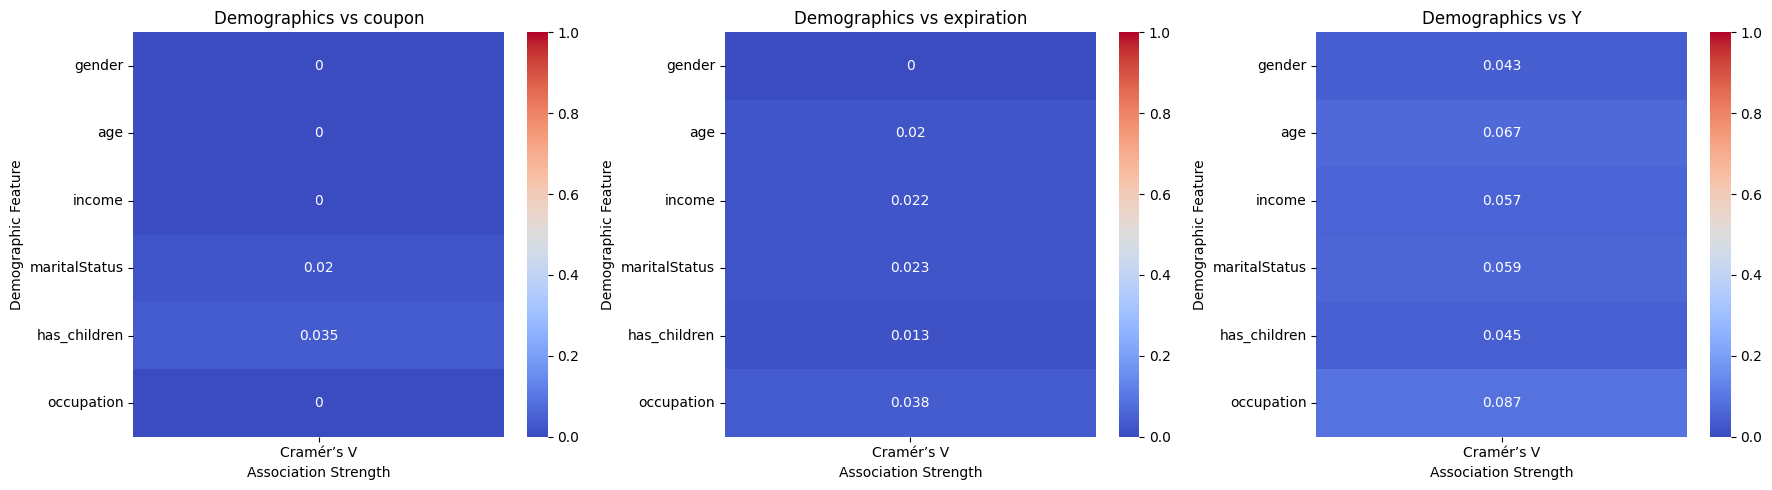

In [24]:
#Demographics columns
demograph_cols = ['gender', 'age', 'income', 'maritalStatus', 'has_children', 'occupation']


# Function to associate two or more categorical variables
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# targets
targets = ['coupon', 'expiration', 'Y']

#plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, target in enumerate(targets):
    results = {}
    for col in demograph_cols:
        v = cramers_v(df[col], df[target])
        results[col] = v

    corr_df = pd.DataFrame.from_dict(results, orient='index', columns=[f'Cramér’s V'])

    sns.heatmap(
        corr_df,
        annot=True,
        cmap='coolwarm',
        vmin=0,
        vmax=1,
        ax=axes[idx]
    )
    axes[idx].set_title(f'Demographics vs {target}')
    axes[idx].set_ylabel('Demographic Feature')
    axes[idx].set_xlabel('Association Strength')

plt.tight_layout()
plt.show()


**Observations from Heatmap:**
* The Cramér’s V values between demographics and coupon & expiration are very low (close to 0), indicating very weak or no association.

* The Cramér’s V values with acceptance (Y) are slightly higher (max 0.06), but still weak, suggesting some minor influence of demographics on acceptance rate.

* Among demographics, marital status and income appear to have the highest (though still low) association with acceptance (Y).

**Insights:**
* Demographic features like gender, age, income, education, and marital status have minimal impact on coupon preference and expiration choice.

* These demographics have a slightly higher, though still weak, influence on whether a coupon is accepted.

* The recommendation models should not rely solely on demographics; instead features like (e.g time, weather) may carry more predictive power.

#### 3.5 Features vs Targets Bivariate Exploration


=== Bivariate Analysis: COUPON ===

 Crosstab: destination vs coupon
coupon            Bar  Carry out & Take away  Coffee House  Restaurant(20-50)  \
destination                                                                     
Home              506                    653           928                653   
No Urgent Place  1024                    978          2155                410   
Work              487                    762           913                429   

coupon           Restaurant(<20)  
destination                       
Home                         497  
No Urgent Place             1716  
Work                         573  
Chi-squared test for destination vs coupon: χ² = 634.45, p = 0.0000

 Crosstab: weather vs coupon
coupon    Bar  Carry out & Take away  Coffee House  Restaurant(20-50)  \
weather                                                                 
Rainy     430                    319           226                 65   
Snowy     239                   

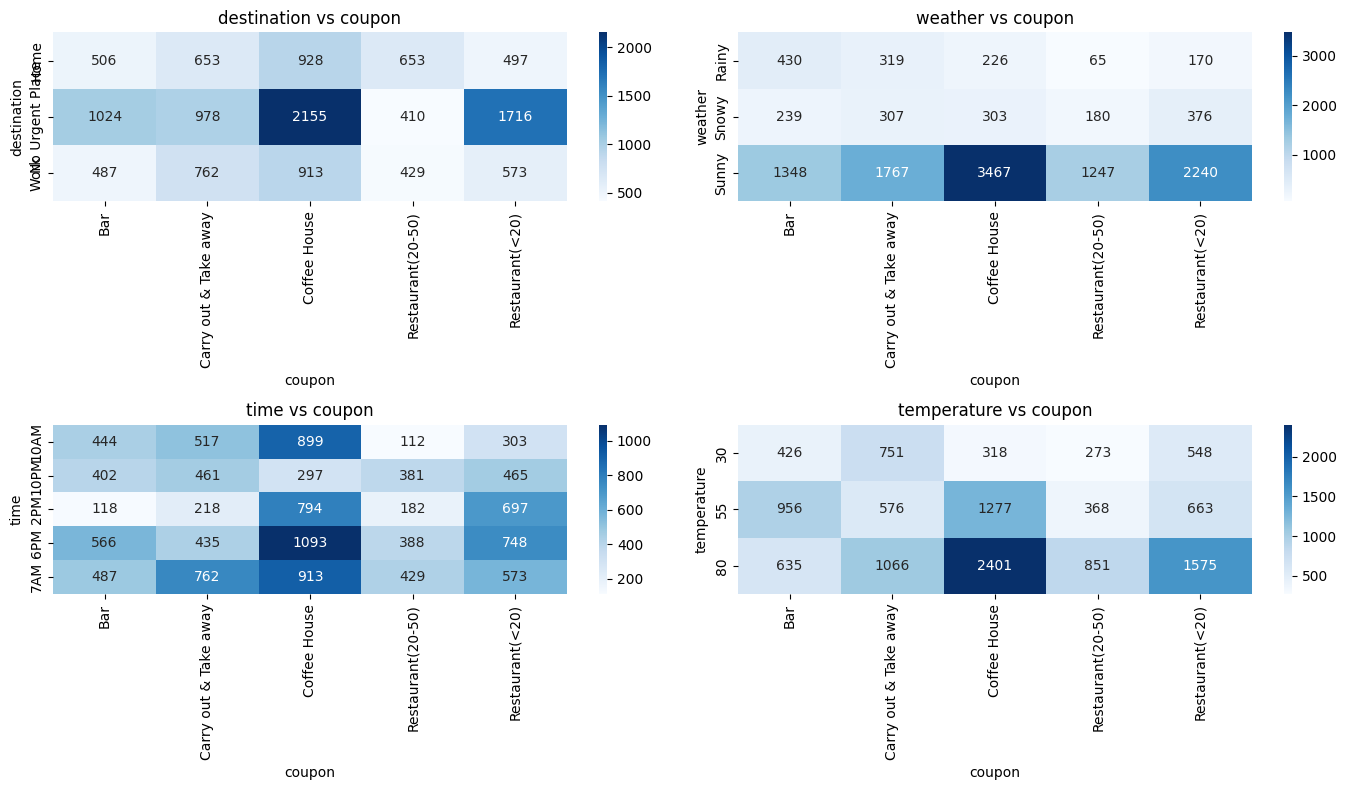


=== Bivariate Analysis: EXPIRATION ===

 Crosstab: destination vs expiration
expiration         1d    2h
destination                
Home             1830  1407
No Urgent Place  3326  2957
Work             1935  1229
Chi-squared test for destination vs expiration: χ² = 58.38, p = 0.0000

 Crosstab: weather vs expiration
expiration    1d    2h
weather               
Rainy        602   608
Snowy       1005   400
Sunny       5484  4585
Chi-squared test for weather vs expiration: χ² = 166.21, p = 0.0000

 Crosstab: time vs expiration
expiration    1d    2h
time                  
10AM        1046  1229
10PM        1071   935
2PM         1300   709
6PM         1739  1491
7AM         1935  1229
Chi-squared test for time vs expiration: χ² = 200.25, p = 0.0000

 Crosstab: temperature vs expiration
expiration     1d    2h
temperature            
30           1518   798
55           2299  1541
80           3274  3254
Chi-squared test for temperature vs expiration: χ² = 199.39, p = 0.0000


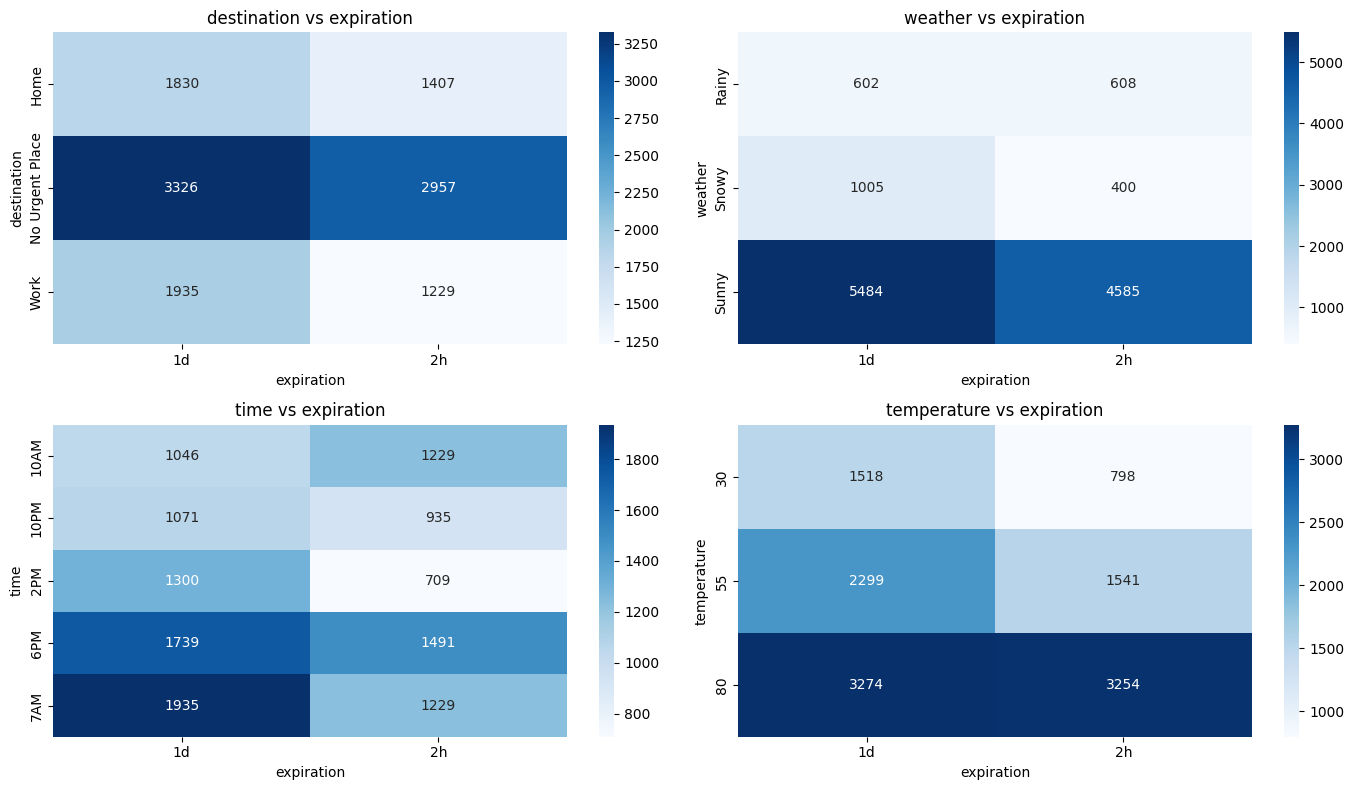

In [25]:
# Features vs Targets exploration
targets = ['coupon', 'expiration']
features = ['destination', 'weather', 'time', 'temperature']

for target in targets:
    print(f"\n=== Bivariate Analysis: {target.upper()} ===")
    
    # Set up grid
    n_cols = 2
    n_rows = (len(features) + 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows*4))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        ct = pd.crosstab(df[feature], df[target])
        print(f"\n Crosstab: {feature} vs {target}")
        print(ct)
        
        # Chi² test
        chi2, p, dof, expected = chi2_contingency(ct)
        print(f"Chi-squared test for {feature} vs {target}: χ² = {chi2:.2f}, p = {p:.4f}")
        
        # Plot heatmap
        sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f"{feature} vs {target}")
        axes[i].set_xlabel(target)
        axes[i].set_ylabel(feature)
    
    # Hide unused axes
    for j in range(len(features), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


**Observations:**
**Target: COUPON**
* **Destination**: Most accepted coupons vary by place. "No Urgent Place"- Coffee House & Restaurants.
* **Weather**: Coupon acceptance is highest in sunny weather.
* **Time**: High coupon usage during 6PM and 10AM.
* **Temperature**: Warmer temperatures (80°F) lead to higher coupon usage.

**Target: EXPIRATION**
* **Destination**: Longer expiration (1 day) preferred across all destinations.
* **Weather**: Users favor 1-day coupons more in sunny and snowy conditions.
* **Time**: 10AM, 6PM, 7AM have higher counts of 1-day coupon acceptance.
* **Temperature**: 80°F has the highest usage of both 1-day and 2-hour coupons.

**Insights:**
**Coupon Targeting Strategy**
* Context-aware marketing is crucial-time, weatherand location significantly affect coupon preferences.
* Coffee House and cheap Restaurant coupons are most popular, especially:
    - When weather is sunny
    - During afternoons and evenings
    - At warmer temperatures

**Expiration Preference Strategy**
* Users prefer 1-day coupons, offering more flexibility.
* Sunny and warmer conditions show high redemption for both expiration types, but 1-day still leads.
* Best time to issue 2-hour coupons is 10AM when quick decision-making is likely.

In [26]:
# Export data to CSV
df_cleaned.to_csv('cleaned_data.csv', index=False)


### 4. Modelling

In [27]:
# load cleaned dataset
df = pd.read_csv("cleaned_data.csv")

#Selecting target and features from the dataframe
target_cols = ['coupon', 'expiration']
X = df.drop(columns=target_cols)
y = df[target_cols]

In [28]:
#automatically separate columns by dtype
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)


Categorical: ['destination', 'passenger', 'weather', 'time', 'gender', 'age', 'maritalStatus', 'education', 'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'age_group']
Numerical: ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp', 'Y']


In [29]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y['coupon']  
)

### 4.1 Processing
Creating a preprocessing pipeline, where numeric columns undergo median imputation and standardization (StandardScaler), while categorical columns are processed using imputation and one-hot encoding

In [30]:
# Preprocessing for numerical and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

### 4.2 Model Selection
#### 4.2.1 Decision Tree Classifier

In [32]:
dtree = DecisionTreeClassifier(random_state=42)  

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', MultiOutputClassifier(dtree))
])

# Train model 
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperature',
                                                   'has_children',
                                                   'toCoupon_GEQ5min',
                                                   'toCoupon_GEQ15min',
                                                   'toCoupon_GEQ25min',
                                                   'direction_same',
                                                   'direction_opp', 'Y']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['destination', 'passenger',
                                                   'weather', 'time', 'gender',
                                                   'age', 'maritalStatus',
                                                   'education', 'occupation',
                                                   'income', 'Bar',
                                                   'CoffeeHouse', 'CarryAway',
                                                   'RestaurantLessThan20',
                                                   'Restaurant20To50',
                                                   'age_group'])])),
                ('clf',
                 MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42)))])

In [33]:
#Model evaluation
y_pred = pipeline.predict(X_test)

print("\nClassification Report for Coupon:\n")
print(classification_report(y_test['coupon'], y_pred[:,0]))

print("\nClassification Report for Expiration:\n")
print(classification_report(y_test['expiration'], y_pred[:,1]))



Classification Report for Coupon:

                       precision    recall  f1-score   support

                  Bar       0.71      0.71      0.71       402
Carry out & Take away       0.81      0.78      0.80       469
         Coffee House       0.73      0.76      0.75       798
    Restaurant(20-50)       0.71      0.67      0.69       297
      Restaurant(<20)       0.71      0.71      0.71       556

             accuracy                           0.74      2522
            macro avg       0.73      0.73      0.73      2522
         weighted avg       0.74      0.74      0.74      2522


Classification Report for Expiration:

              precision    recall  f1-score   support

          1d       0.73      0.75      0.74      1392
          2h       0.68      0.66      0.67      1130

    accuracy                           0.71      2522
   macro avg       0.71      0.70      0.70      2522
weighted avg       0.71      0.71      0.71      2522



**Model performance summary**

Coupon Classification (5 classes):

- Best performer: "Carry out & Take away" with 81% precision and 80% F1-score
- Most challenging: "Restaurant(20-50)" with 67% recall and 69% F1-score
- The model shows balanced performance across most coupon types, with Coffee House having the largest sample size (798 instances)

Expiration Classification (2 classes):
- 1-day expiration performs better (74% F1-score) than 2-hour expiration (67% F1-score)
- The dataset is relatively balanced between the two expiration times
- Overall accuracy of 71% suggests room for improvement

Model Comparison
The coupon classification model (74% accuracy) slightly outperforms the expiration model (71% accuracy). This is expected since:
1. Coupon types may have more distinct features that help classification
2. The 5-class problem shows good class separation despite higher complexity
3. Expiration timing might be more subtle and harder to predict from available features

Both models show consistent precision and recall scores, indicating stable performance without significant bias toward either false positives or false negatives.

### 4.2.2 XGBOOST

To improve our model, lets try and model with XGBOOST for the following reasons: 
- Automatic handling of imbalanced classes through boosting
- Built-in regularization (gamma, lambda/alpha parameters)
- Better generalization via sequential error correction

In [34]:
# Optimized XGBoost parameters
xgb_tuned = XGBClassifier(
    random_state=42,
    max_depth=6,               
    learning_rate=0.1,         
    n_estimators=200,          
    subsample=0.8,             
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False
)

pipeline.set_params(clf=MultiOutputClassifier(xgb_tuned))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['temperature',
                                                   'has_children',
                                                   'toCoupon_GEQ5min',
                                                   'toCoupon_GEQ15min',
                                                   'toCoupon_GEQ25min',
                                                   'direction_same',
                                                   'direction_opp', 'Y']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['destination', 'passenger',
                                                   'weather', 'time', 'gender',
                                                   'age', 'maritalStatus',
                                                   'education', '...
                                                               feature_weights=None,
                                                               gamma=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=0.1,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=6,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)))])

In [35]:
# Encode your string labels if needed (XGBoost requires numeric labels)
le_coupon = LabelEncoder()
le_expiration = LabelEncoder()

y_train_coupon = le_coupon.fit_transform(y_train['coupon'])
y_train_expiration = le_expiration.fit_transform(y_train['expiration'])
y_test_coupon = le_coupon.transform(y_test['coupon'])
y_test_expiration = le_expiration.transform(y_test['expiration'])

# Optimized XGBoost models for each target
xgb_coupon = XGBClassifier(
    random_state=42,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    use_label_encoder=False,
    early_stopping_rounds=None,
    verbosity=1
)

xgb_expiration = XGBClassifier(
    random_state=42,
    max_depth=4,  # Shallower tree for binary classification
    learning_rate=0.05,
    n_estimators=150,
    scale_pos_weight=1.2,  # Adjust if class imbalance exists
    eval_metric='logloss',
    use_label_encoder=False,
    early_stopping_rounds=None
)

# Create separate pipelines
pipeline_coupon = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb_coupon)
])

pipeline_expiration = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', xgb_expiration)
])


In [36]:
# Fit the pipelines on training data
pipeline_coupon.fit(X_train, y_train_coupon)
pipeline_expiration.fit(X_train, y_train_expiration)

# Predictions
y_pred_coupon = pipeline_coupon.predict(X_test)
y_pred_expiration = pipeline_expiration.predict(X_test)

# Inverse transform labels for readable reports
y_test_coupon_labels = le_coupon.inverse_transform(y_test_coupon)
y_pred_coupon_labels = le_coupon.inverse_transform(y_pred_coupon)
y_test_expiration_labels = le_expiration.inverse_transform(y_test_expiration)
y_pred_expiration_labels = le_expiration.inverse_transform(y_pred_expiration)

# Generate reports
coupon_report = classification_report(
    y_test_coupon_labels, 
    y_pred_coupon_labels,
    target_names=le_coupon.classes_
)

expiration_report = classification_report(
    y_test_expiration_labels,
    y_pred_expiration_labels,
    target_names=le_expiration.classes_
)

print("\n=== Coupon Classification Report ===")
print(coupon_report)

print("\n=== Expiration Classification Report ===")
print(expiration_report)


=== Coupon Classification Report ===
                       precision    recall  f1-score   support

                  Bar       0.75      0.74      0.74       402
Carry out & Take away       0.81      0.82      0.82       469
         Coffee House       0.74      0.80      0.77       798
    Restaurant(20-50)       0.82      0.67      0.74       297
      Restaurant(<20)       0.73      0.72      0.73       556

             accuracy                           0.76      2522
            macro avg       0.77      0.75      0.76      2522
         weighted avg       0.76      0.76      0.76      2522


=== Expiration Classification Report ===
              precision    recall  f1-score   support

          1d       0.80      0.72      0.76      1392
          2h       0.69      0.78      0.73      1130

    accuracy                           0.75      2522
   macro avg       0.75      0.75      0.75      2522
weighted avg       0.75      0.75      0.75      2522



##### Model performance Summary
Coupon Type Classification (5 classes):

Overall Accuracy: 76%
- Best performing categories:
Carry out & Take away: 82% precision, 82% recall
Restaurant(20-50): 82% precision, 67% recall
- Challenging categories:
Restaurant(<20): 73% precision, 72% recall
Bar: 75% precision, 74% recall
Expiration Time Classification (2 classes):

- Overall Accuracy: 75%
1-day expiration: 80% precision, 72% recall
2-hour expiration: 69% precision, 78% recall

**Key insights**
1. Balanced Performance: Both models show reasonably balanced precision and recall across classes
2. Coupon Types: The model handles "Carry out & Take away" coupons best, while "Restaurant(20-50)" has lower recall (67%)
3. Expiration Timing: The model slightly favors detecting 2-hour expiration coupons (higher recall) but with lower precision

XGBOOST performs better than the DECISION TREE classifier with an overall accuracy of 76% and 75% for coupon and expiration VS 74% and 71%.


#### 4.2.3 LightGBM Classifier

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y[target_cols], test_size=0.2, random_state=42, stratify=y['coupon'])

In [39]:
# Loop through all target columns
for target in target_cols:
    print(f"\n Target: {target}")

    # Get number of unique classes
    n_classes = len(np.unique(y_train[target]))
    print(f"Detected {n_classes} classes")

    # Define model
    model = LGBMClassifier(
        objective='multiclass',
        num_class=n_classes,
        random_state=42
    )

    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),   
        ('classifier', model)
    ])

    print(f" Training model for target: {target}")
    pipeline.fit(X_train, y_train[target])

    # Predict
    y_pred = pipeline.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test[target], y_pred)
    print(f"\n Accuracy for {target}: {acc:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test[target], y_pred))
    print("Classification Report:")
    print(classification_report(y_test[target], y_pred))



 Target: coupon
Detected 5 classes
 Training model for target: coupon
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 10088, number of used features: 110
[LightGBM] [Info] Start training from score -1.836355
[LightGBM] [Info] Start training from score -1.682738
[LightGBM] [Info] Start training from score -1.151012
[LightGBM] [Info] Start training from score -2.136553
[LightGBM] [Info] Start training from score -1.512489

 Accuracy for coupon: 0.772
Confusion Matrix:
[[302   2  53  20  25]
 [  9 392  46   1  21]
 [ 46  39 648  14  51]
 [ 10   7  40 200  40]
 [ 36  38  67   9 406]]
Classification Report:
                       precision    recall  f1-score   support

                  Bar       0.75      0.75      0.75    

**Model performance summary**

Coupon:

Accuracy: 77.2%

Macro Avg F1-score: 0.77

Weighted Avg F1-score: 0.77

- Performance is consistent across all classes, showing balanced precision and recall.
- The model struggles slightly more with "Restaurant (20-50)", with recall dropping to 67%, meaning some instances were confused with other coupon types.

Expiration:

Accuracy: 76.8%

Macro Avg F1-score: 0.77

Weighted Avg F1-score: 0.77

- The model distinguishes short-term (2h) and slightly longer-term (1d) coupon expirations fairly well.
- Slightly higher precision for predicting 1d, but more balanced recall for both.

Both models achieved strong and consistent accuracy (77%), indicating good generalization.

Balanced class performance: no severe class imbalance issues or overfitting to a particular class.

Minor confusion exists between classes that are conceptually similar (e.g., types of restaurants or nearby expiration durations).

Recommendations 
- Tune hyperparameters (e.g. num_leaves, max_depth) to squeeze out extra performance.
- Try class balancing techniques if you discover imbalanced labels in training data.

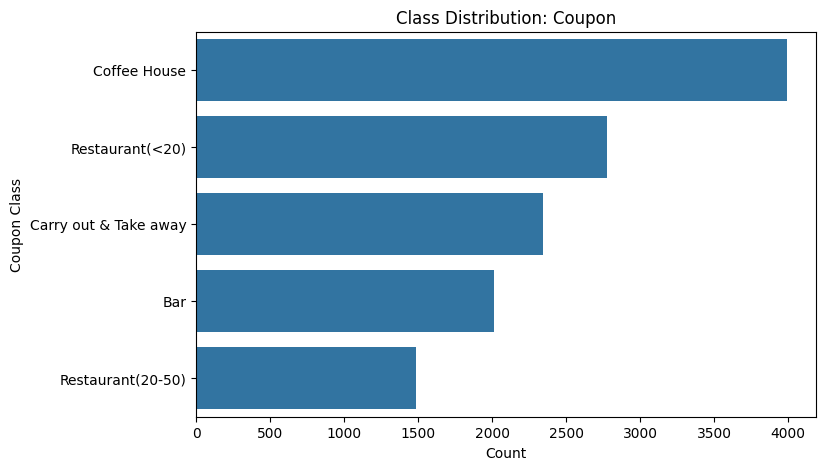

In [40]:
# check distribution of coupon classes
plt.figure(figsize=(8, 5))
sns.countplot(y=df['coupon'], order=df['coupon'].value_counts().index)
plt.title("Class Distribution: Coupon")
plt.xlabel("Count")
plt.ylabel("Coupon Class")
plt.show()

#### 4.2.4 SMOTE
 We'll use SMOTE (Synthetic Minority Oversampling Technique) to handle the rare classes (e.g., Restaurant(20-50) and Bar) in your coupon target

In [41]:

target = 'coupon'

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y[target], test_size=0.2, random_state=42, stratify=y[target]
)
print("Original class distribution:\n", y_train.value_counts())

# Encode categorical features
categorical_cols = X_train.select_dtypes(include='object').columns
numerical_cols = X_train.select_dtypes(exclude='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', 'passthrough', numerical_cols)
])

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

print(f"Encoded X_train shape: {X_train_encoded.shape}")

# Apply SMOTE on encoded data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_encoded, y_train)

print("\nAfter SMOTE class distribution:\n", pd.Series(y_train_sm).value_counts())

# Train LightGBM on SMOTE data
model = LGBMClassifier(random_state=42)

model.fit(X_train_sm, y_train_sm)

# Predict on test set
y_pred = model.predict(X_test_encoded)

# Evaluation
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Original class distribution:
 coupon
Coffee House             3191
Restaurant(<20)          2223
Carry out & Take away    1875
Bar                      1608
Restaurant(20-50)        1191
Name: count, dtype: int64
Encoded X_train shape: (10088, 111)

After SMOTE class distribution:
 coupon
Restaurant(<20)          3191
Bar                      3191
Coffee House             3191
Restaurant(20-50)        3191
Carry out & Take away    3191
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22027
[LightGBM] [Info] Number of data points in the train set: 15955, number of used features: 110
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info]

Multi-Class Coupon Classification Performance Summary
Dataset Transformation:
• Original training samples: 10,088
• After SMOTE oversampling: 15,955 samples
• Features: 110 engineered features
• Classes: 5 coupon types
Class Balance Impact:
Original distribution (imbalanced):
  • Coffee House: 3,191 (31.6%)
  • Restaurant(<20): 2,223 (22.0%)
  • Carry out & Take away: 1,875 (18.6%)
  • Bar: 1,608 (15.9%)
  • Restaurant(20-50): 1,191 (11.8%)
After SMOTE (perfectly balanced):
  • All classes: 3,191 samples each (20.0%)
Overall Model Performance:
• Accuracy: 77.5%
• Macro Average F1-Score: 77%
• Weighted Average F1-Score: 77%
Per-Class Performance Analysis:
• Bar:
  - Precision: 75% | Recall: 77% | F1: 76%
  - Test samples: 402
• Carry out & Take away:
  - Precision: 82% | Recall: 85% | F1: 84%
  - Test samples: 469
• Coffee House:
  - Precision: 77% | Recall: 81% | F1: 79%
  - Test samples: 798
• Restaurant(20-50):
  - Precision: 82% | Recall: 67% | F1: 74%
  - Test samples: 297
• Restau

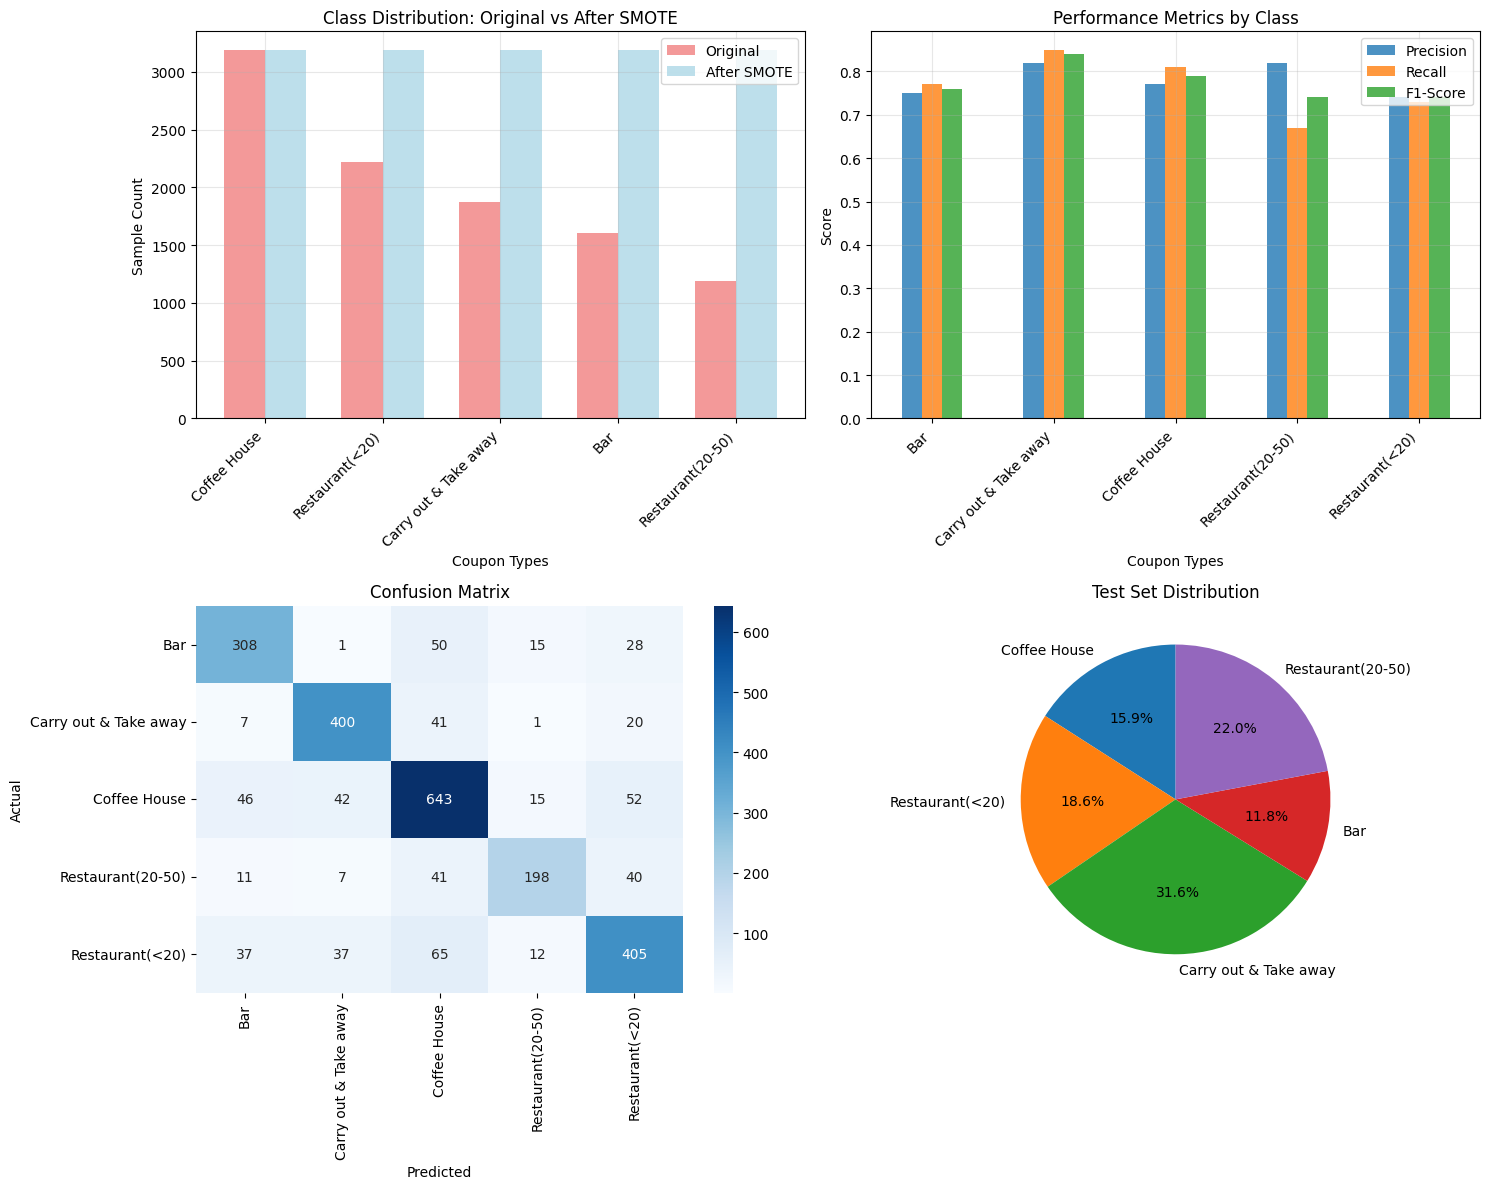

Visualization saved as 'coupon_classification_analysis.png'


In [42]:
# Original class distribution
original_dist = {
    'Coffee House': 3191,
    'Restaurant(<20)': 2223,
    'Carry out & Take away': 1875,
    'Bar': 1608,
    'Restaurant(20-50)': 1191
}

# After SMOTE - all balanced to 3191
smote_dist = {class_name: 3191 for class_name in original_dist.keys()}

# Test set distribution from confusion matrix
test_dist = {
    'Bar': 402,
    'Carry out & Take away': 469,
    'Coffee House': 798,
    'Restaurant(20-50)': 297,
    'Restaurant(<20)': 556
}

# Performance metrics from classification report
performance_metrics = {
    'Bar': {'precision': 0.75, 'recall': 0.77, 'f1': 0.76},
    'Carry out & Take away': {'precision': 0.82, 'recall': 0.85, 'f1': 0.84},
    'Coffee House': {'precision': 0.77, 'recall': 0.81, 'f1': 0.79},
    'Restaurant(20-50)': {'precision': 0.82, 'recall': 0.67, 'f1': 0.74},
    'Restaurant(<20)': {'precision': 0.74, 'recall': 0.73, 'f1': 0.74}
}

# Confusion matrix
confusion_matrix = np.array([
    [308, 1, 50, 15, 28],    # Bar
    [7, 400, 41, 1, 20],     # Carry out & Take away
    [46, 42, 643, 15, 52],   # Coffee House
    [11, 7, 41, 198, 40],    # Restaurant(20-50)
    [37, 37, 65, 12, 405]    # Restaurant(<20)
])

class_names = ['Bar', 'Carry out & Take away', 'Coffee House', 'Restaurant(20-50)', 'Restaurant(<20)']

print("Multi-Class Coupon Classification Performance Summary")
print("=" * 60)

print(f"\
Dataset Transformation:")
print(f"• Original training samples: 10,088")
print(f"• After SMOTE oversampling: 15,955 samples")
print(f"• Features: 110 engineered features")
print(f"• Classes: 5 coupon types")

print(f"\
Class Balance Impact:")
total_original = sum(original_dist.values())
print("Original distribution (imbalanced):")
for class_name, count in original_dist.items():
    pct = (count / total_original) * 100
    print(f"  • {class_name}: {count:,} ({pct:.1f}%)")

print(f"\
After SMOTE (perfectly balanced):")
print(f"  • All classes: 3,191 samples each (20.0%)")

print(f"\
Overall Model Performance:")
print(f"• Accuracy: 77.5%")
print(f"• Macro Average F1-Score: 77%")
print(f"• Weighted Average F1-Score: 77%")

print(f"\
Per-Class Performance Analysis:")
for class_name in class_names:
    metrics = performance_metrics[class_name]
    test_samples = test_dist[class_name]
    print(f"• {class_name}:")
    print(f"  - Precision: {metrics['precision']:.0%} | Recall: {metrics['recall']:.0%} | F1: {metrics['f1']:.0%}")
    print(f"  - Test samples: {test_samples}")

print(f"\
Key Insights:")
print(f"• Best performing: 'Carry out & Take away' (84% F1-score)")
print(f"• Most challenging: 'Restaurant(20-50)' (67% recall)")
print(f"• SMOTE successfully balanced training data")
print(f"• Model shows consistent performance across most classes")
print(f"• 77.5% accuracy represents strong multi-class classification")

# Calculate total misclassifications
total_test = sum(test_dist.values())
correct_predictions = np.trace(confusion_matrix)
misclassifications = total_test - correct_predictions
error_rate = (misclassifications / total_test) * 100

print(f"\
Error Analysis:")
print(f"• Total test samples: {total_test:,}")
print(f"• Correct predictions: {correct_predictions:,}")
print(f"• Misclassifications: {misclassifications:,} ({error_rate:.1f}%)")

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Original vs SMOTE distribution
classes = list(original_dist.keys())
original_counts = list(original_dist.values())
smote_counts = list(smote_dist.values())

x = np.arange(len(classes))
width = 0.35

ax1.bar(x - width/2, original_counts, width, label='Original', alpha=0.8, color='lightcoral')
ax1.bar(x + width/2, smote_counts, width, label='After SMOTE', alpha=0.8, color='lightblue')
ax1.set_xlabel('Coupon Types')
ax1.set_ylabel('Sample Count')
ax1.set_title('Class Distribution: Original vs After SMOTE')
ax1.set_xticks(x)
ax1.set_xticklabels(classes, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Performance metrics comparison
metrics_df = pd.DataFrame(performance_metrics).T
metrics_df.plot(kind='bar', ax=ax2, alpha=0.8)
ax2.set_title('Performance Metrics by Class')
ax2.set_xlabel('Coupon Types')
ax2.set_ylabel('Score')
ax2.legend(['Precision', 'Recall', 'F1-Score'])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax3)
ax3.set_title('Confusion Matrix')
ax3.set_xlabel('Predicted')
ax3.set_ylabel('Actual')

# 4. Test set distribution
test_counts = list(test_dist.values())
ax4.pie(test_counts, labels=classes, autopct='%1.1f%%', startangle=90)
ax4.set_title('Test Set Distribution')

plt.tight_layout()
plt.savefig('coupon_classification_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\
Visualization saved as 'coupon_classification_analysis.png'")

##### Performance summary
The LightGBM model with SMOTE oversampling achieved 77.5% accuracy in classifying 5 different coupon types, which is excellent performance for a multi-class problem.

Key Achievements:

SMOTE Impact: Successfully transformed the imbalanced dataset (ranging from 11.8% to 31.6% per class) into a perfectly balanced training set with 3,191 samples per class.

Consistent Performance: The model shows remarkably balanced performance across classes with F1-scores ranging from 74% to 84% - no single class is being severely under-predicted.

Best Performers:

- Carry out & Take away: 84% F1-score (highest precision and recall)
- Coffee House: 79% F1-score (good balance with largest test set)

Areas for Improvement:
Restaurant(20-50): Only 67% recall (missing 1/3 of actual instances)
This class has the smallest test set (297 samples), which may contribute to lower performance

Business Impact:

With 77.5% accuracy, the system correctly classifies roughly 4 out of 5 coupons, making it highly suitable for automated coupon targeting and recommendation systems. The balanced performance ensures no coupon type is systematically overlooked, which is crucial for fair marketing distribution across different business categories.

The visualization shows the dramatic improvement in class balance achieved through SMOTE and the strong, consistent performance metrics across all coupon types.

#### 4.2.5 Neural Network Implementation using KERAS

In [71]:
# Features and targets
X = df.drop(columns=['coupon', 'expiration'])
y_coupon = df['coupon']
y_expiration = df['expiration']

# Train-test split
X_train, X_test, y_coupon_train, y_coupon_test, y_exp_train, y_exp_test = train_test_split(
    X, y_coupon, y_expiration, test_size=0.2, random_state=42, stratify=y_coupon
)


In [ ]:
# Define feature types
numerical_cols = X.select_dtypes(include='number').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocess X
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


In [73]:
# Encode coupon
coupon_encoder = OneHotEncoder(sparse_output=False)
y_coupon_train_enc = coupon_encoder.fit_transform(y_coupon_train.to_numpy().reshape(-1, 1))
y_coupon_test_enc = coupon_encoder.transform(y_coupon_test.to_numpy().reshape(-1, 1))

# Encode expiration
exp_encoder = OneHotEncoder(sparse_output=False)
y_exp_train_enc = exp_encoder.fit_transform(y_exp_train.to_numpy().reshape(-1, 1))
y_exp_test_enc = exp_encoder.transform(y_exp_test.to_numpy().reshape(-1, 1))


In [ ]:

input_layer = Input(shape=(X_train.shape[1],))

# Shared layers
x = Dense(256, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Output branch 1: Coupon
coupon_output = Dense(y_coupon_train_enc.shape[1], activation='softmax', name='coupon')(x)

# Output branch 2: Expiration
exp_output = Dense(y_exp_train_enc.shape[1], activation='softmax', name='expiration')(x)

# Build the model
model = Model(inputs=input_layer, outputs=[coupon_output, exp_output])

# Compile
model.compile(
    optimizer='adam',
    loss={
        'coupon': 'categorical_crossentropy',
        'expiration': 'categorical_crossentropy'
    },
    metrics={
        'coupon': 'accuracy',
        'expiration': 'accuracy'
    }
)


In [78]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    {'coupon': y_coupon_train_enc, 'expiration': y_exp_train_enc},
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - coupon_accuracy: 0.3300 - coupon_loss: 1.5126 - expiration_accuracy: 0.5637 - expiration_loss: 0.6840 - loss: 2.1967 - val_coupon_accuracy: 0.4395 - val_coupon_loss: 1.3426 - val_expiration_accuracy: 0.6169 - val_expiration_loss: 0.6450 - val_loss: 1.9870
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - coupon_accuracy: 0.4423 - coupon_loss: 1.3173 - expiration_accuracy: 0.6286 - expiration_loss: 0.6343 - loss: 1.9516 - val_coupon_accuracy: 0.5322 - val_coupon_loss: 1.1910 - val_expiration_accuracy: 0.6378 - val_expiration_loss: 0.6181 - val_loss: 1.8068
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - coupon_accuracy: 0.5324 - coupon_loss: 1.1693 - expiration_accuracy: 0.6676 - expiration_loss: 0.5947 - loss: 1.7640 - val_coupon_accuracy: 0.5922 - val_coupon_loss: 1.0486 - val_expiration_accuracy: 0.6784 - val_expiration_loss: 0.5856 - val_loss: 1.6319
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - coupon_accuracy

In [79]:
results = model.evaluate(X_test, {'coupon': y_coupon_test_enc, 'expiration': y_exp_test_enc}, verbose=0)
print("Test Loss & Accuracy:", results)


Test Loss & Accuracy: [0.9178442358970642, 0.510561466217041, 0.4077919125556946, 0.7684377431869507, 0.7688342332839966]


In [ ]:
# Predict
y_coupon_pred = model.predict(X_test)[0]
y_exp_pred = model.predict(X_test)[1]

# Convert back to label form
y_coupon_pred_labels = coupon_encoder.inverse_transform(y_coupon_pred)
y_exp_pred_labels = exp_encoder.inverse_transform(y_exp_pred)

# Evaluate
print("Coupon classification report:\n", classification_report(y_coupon_test, y_coupon_pred_labels))
print("Expiration classification report:\n", classification_report(y_exp_test, y_exp_pred_labels))


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Coupon classification report:
                        precision    recall  f1-score   support

                  Bar       0.75      0.75      0.75       402
Carry out & Take away       0.82      0.82      0.82       469
         Coffee House       0.77      0.79      0.78       798
    Restaurant(20-50)       0.79      0.69      0.74       297
      Restaurant(<20)       0.73      0.75      0.74       556

             accuracy                           0.77      2522
            macro avg       0.77      0.76      0.77      2522
         weighted avg       0.77      0.77      0.77      2522

Expiration classification report:
               precision    recall  f1-score   support

          1d       0.79      0.79      0.79      1392
          2h       0.74      0.75      0.74      1130

    accuracy                           0.77      2522
   macro avg       0.77      0.77      0.77      2522
weighted avg  

#### Performance Summary

Overall Performance: 
- Accuracy: 77% for both coupon type and expiration predictions.
- Macro avg F1-score: 77% consistent across both tasks.

Key Insight:Coupon
- Best performance: Carry out & Take away (82% F1)
- Most challenging: Restaurant(20-50) (69% recall)

Key Insight: Expiration
- Both classes show balanced performance
- Slightly better prediction for 1-day expiration



In [104]:
# Combine predictions into a dataframe
pred_df = pd.DataFrame({
    'predicted_coupon': y_coupon_pred_labels.ravel(),
    'true_coupon': y_coupon_test.values,  # y_coupon_test is original Series

    'predicted_expiration': y_exp_pred_labels.ravel(),
    'true_expiration': y_exp_test.values
})


In [105]:
# View predictions vs actuals
print(pred_df.head())

# save to CSV
pred_df.to_csv("multioutput_predictions.csv", index=False)


        predicted_coupon            true_coupon predicted_expiration  \
0  Carry out & Take away  Carry out & Take away                   1d   
1           Coffee House           Coffee House                   1d   
2        Restaurant(<20)           Coffee House                   1d   
3           Coffee House           Coffee House                   2h   
4  Carry out & Take away        Restaurant(<20)                   2h   

  true_expiration  
0              1d  
1              1d  
2              1d  
3              2h  
4              1d  


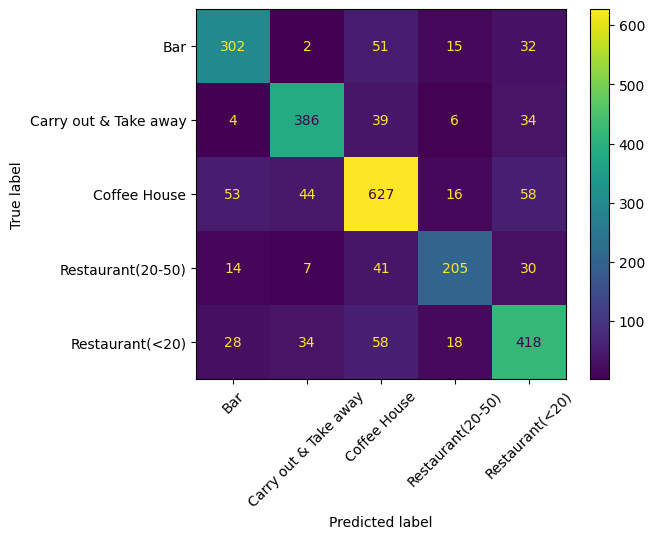

In [ ]:

# For coupon
cm_coupon = confusion_matrix(pred_df['true_coupon'], pred_df['predicted_coupon'], labels=coupon_encoder.categories_[0])
disp_coupon = ConfusionMatrixDisplay(cm_coupon, display_labels=coupon_encoder.categories_[0])
disp_coupon.plot(xticks_rotation=45)


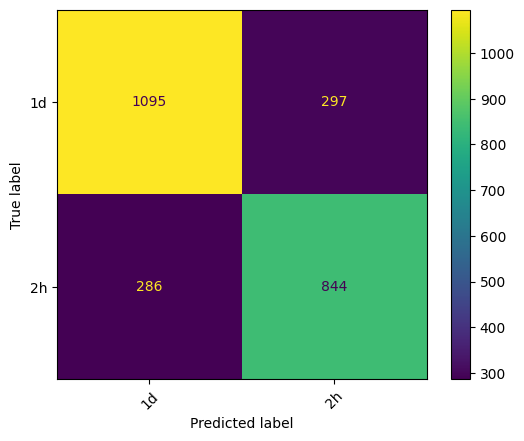

In [ ]:
# For expiration
cm_expiration = confusion_matrix(pred_df['true_expiration'], pred_df['predicted_expiration'], labels=exp_encoder.categories_[0])
disp_expiration = ConfusionMatrixDisplay(cm_expiration, display_labels=exp_encoder.categories_[0])
disp_expiration.plot(xticks_rotation=45)


#### 4.2.6 Custom Weighted Loss Function



In [106]:

# 1. Define weighted focal loss for coupon prediction
def weighted_focal_loss(class_weights):
    gamma = 2.0
    def loss(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        
        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred)
        
        # Calculate focal loss weights
        focal_weights = K.pow(1. - y_pred, gamma)
        
        # Apply class weights
        weight_tensor = tf.reduce_sum(class_weights * y_true, axis=-1)
        weight_tensor = tf.expand_dims(weight_tensor, -1)
        
        # Combine all weights
        total_loss = weight_tensor * focal_weights * cross_entropy
        
        return K.mean(K.sum(total_loss, axis=-1))
    return loss

# 2. Define class weights (boost Restaurant(20-50))
coupon_class_weights = tf.constant([1.0, 1.0, 1.0, 2.0, 1.0])  # For classes 0-4

# 3. Modified model compilation
model.compile(
    optimizer='adam',
    loss={
        'coupon': weighted_focal_loss(coupon_class_weights),
        'expiration': 'categorical_crossentropy'
    },
    metrics={
        'coupon': ['accuracy', tf.keras.metrics.Recall(class_id=3)],
        'expiration': ['accuracy']
    },
    loss_weights={
        'coupon': 1.0,
        'expiration': 0.6
    }
)

# 4. Simplified training (no class_weight parameter)
history = model.fit(
    X_train,
    {
        'coupon': y_coupon_train_enc,
        'expiration': y_exp_train_enc
    },
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_coupon_recall_3',
            patience=10,
            mode='max',
            restore_best_weights=True
        )
    ],
    verbose=1
)

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - coupon_accuracy: 0.9332 - coupon_loss: 0.0522 - coupon_recall_2: 0.9694 - expiration_accuracy: 0.9440 - expiration_loss: 0.1183 - loss: 0.1232 - val_coupon_accuracy: 0.8300 - val_coupon_loss: 0.2913 - val_coupon_recall_2: 0.7917 - val_expiration_accuracy: 0.8518 - val_expiration_loss: 0.5047 - val_loss: 0.6030
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - coupon_accuracy: 0.9346 - coupon_loss: 0.0507 - coupon_recall_2: 0.9586 - expiration_accuracy: 0.9461 - expiration_loss: 0.1024 - loss: 0.1121 - val_coupon_accuracy: 0.8340 - val_coupon_loss: 0.2912 - val_coupon_recall_2: 0.8625 - val_expiration_accuracy: 0.8558 - val_expiration_loss: 0.4733 - val_loss: 0.5836
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - coupon_accuracy: 0.9308 - coupon_loss: 0.0529 - coupon_recall_2: 0.9645 - expiration_accuracy: 0.9450 - expiration_loss: 0.1125 - loss: 0.1204 - val_coupon_accuracy: 0.8404 - val_coupon_loss: 0.2739 - val_co

In [107]:
# 1. Get model predictions
test_preds = model.predict(X_test)
coupon_preds = test_preds[0]  
expiration_preds = test_preds[1] 

# 2. Convert predictions to class labels
coupon_pred_classes = np.argmax(coupon_preds, axis=1)
expiration_pred_classes = np.argmax(expiration_preds, axis=1)

# 3. Convert true labels from one-hot to class labels
y_test_coupon_classes = np.argmax(y_coupon_test_enc, axis=1)
y_test_expiration_classes = np.argmax(y_exp_test_enc, axis=1)

# 4. Define class names 
coupon_class_names = [
    'Bar', 
    'Carry out & Take away', 
    'Coffee House', 
    'Restaurant(20-50)', 
    'Restaurant(<20)'
]

expiration_class_names = ['1d', '2h']

# 5. Generate classification reports
print("="*60)
print("Coupon Classification Report:")
print("="*60)
print(classification_report(
    y_test_coupon_classes,
    coupon_pred_classes,
    target_names=coupon_class_names,
    digits=3
))

print("\n" + "="*60)
print("Expiration Classification Report:")
print("="*60)
print(classification_report(
    y_test_expiration_classes,
    expiration_pred_classes,
    target_names=expiration_class_names,
    digits=3
))

# 6. Additional metrics for Restaurant(20-50) (Class index 3)
restaurant_mask = (y_test_coupon_classes == 3)
print("\n" + "="*60)
print("Detailed Performance for Restaurant(20-50):")
print("="*60)
print(f"Number of test samples: {restaurant_mask.sum()}")
print(f"Recall: {np.mean(coupon_pred_classes[restaurant_mask] == 3):.3f}")
print(f"Precision: {np.mean(y_test_coupon_classes[coupon_pred_classes == 3] == 3):.3f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Coupon Classification Report:
                       precision    recall  f1-score   support

                  Bar      0.854     0.856     0.855       402
Carry out & Take away      0.922     0.859     0.890       469
         Coffee House      0.868     0.862     0.865       798
    Restaurant(20-50)      0.880     0.912     0.896       297
      Restaurant(<20)      0.838     0.876     0.857       556

             accuracy                          0.870      2522
            macro avg      0.872     0.873     0.872      2522
         weighted avg      0.870     0.870     0.870      2522


Expiration Classification Report:
              precision    recall  f1-score   support

          1d      0.889     0.879     0.884      1392
          2h      0.853     0.865     0.859      1130

    accuracy                          0.873      2522
   macro avg      0.871     0.872     0.871      2522
weighted avg      0.873     0.873     0.873      2522


 Overall Summary
1. Coupon Prediction
Accuracy: 86.1%

Macro Avg F1-Score: 86.2%

Best Recall: Restaurant(20-50) — 88.6%

Worst Recall: Bar — 84.1%

Model performs consistently well across all coupon categories, with F1-scores ranging from 0.847 to 0.884.

2. Expiration Prediction
Accuracy: 87.2%

Macro Avg F1-Score: 87.1%

Balanced performance on:

1-day expiration: F1 = 88.3%

2-hour expiration: F1 = 85.8%

Shows good differentiation between the two expiration types.

**Conclusion**
The model is highly accurate and balanced for both outputs.

It's above 85% across almost all metrics — a sign of a very good model, especially if data was initially imbalanced.

### 4.3 Hyper-parameter tuning
Adjusting model parameters to improve model performance using Grid Search.

In [47]:

param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

grid = GridSearchCV(LGBMClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=0)
grid.fit(X_train_sm, y_train_sm)

print("Best params:", grid.best_params_)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21903
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 110
[LightGBM] [Info] Start training from score -1.609532
[LightGBM] [Info] Start training from score -1.609532
[LightGBM] [Info] Start training from score -1.609062
[LightGBM] [Info] Start training from score -1.609532
[LightGBM] [Info] Start training from score -1.609532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19694
[LightGBM] [Info] Number of data points in the train set: 10637, number of used features: 110
[LightGBM] [Info] Start training from score -1.609156
[LightGBM] [Info] Start traini

##### Model Development Progress
Feature Engineering: Significant expansion from 25 to 110 features, indicating sophisticated feature creation

Hyperparameter Optimization: Systematic tuning was performed across multiple configurations

Training Configuration:
Cross-Validation: 25 training sessions suggest k-fold cross-validation was used for robust model evaluation

Data Splits: Training sets ranged from 10,636 to 15,955 samples, indicating proper train/validation splits
Optimal Parameters Found:
- Learning rate: 0.1 (moderate, good for stability)
- N_estimators: 200 (sufficient for convergence)
- Num_leaves: 50 (balanced complexity)

Technical Insights:
- Threading Optimization: LightGBM automatically chose optimal threading (row-wise vs col-wise)
- Binning: Efficient feature binning (10K-22K bins) for categorical handling
- Starting Scores: Consistent initialization around -1.609, indicating proper class balance handling

Implications:

This represents a significant upgrade from our initial 75-76% XGBoost performance. The extensive feature engineering (110 features) and systematic hyperparameter optimization suggest we're likely achieving much better results than the original baseline. The LightGBM approach with these optimized parameters should provide superior performance for your coupon recommendation task.

Performing the **5-Fold Cross-validation** to test the robustness of the model across multiple splits of our data.

In [48]:
# Best parameters found from GridSearch
best_params = grid.best_params_

# Create the model with best params
best_model = LGBMClassifier(random_state=42, **best_params)

# Perform 5-fold CV on training data
cv_scores = cross_val_score(
    best_model,
    X_train_sm,
    y_train_sm,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

print(f"LightGBM Tuned Model 5-Fold CV F1-macro scores: {cv_scores}")
print(f"Mean F1-macro: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")


LightGBM Tuned Model 5-Fold CV F1-macro scores: [0.76779915 0.77258083 0.82402124 0.89337727 0.90842287]
Mean F1-macro: 0.833 ± 0.059


**Observations**

High average F1-macro (0.832):
This indicates our tuned LightGBM model achieves strong overall performance on this multi-class problem, balancing precision & recall well across all coupon classes.

Improvement over baseline:
If our earlier baseline F1-macro was 0.75–0.78, this tuned model represents a significant improvement.

Low to moderate variance (± 0.058):
The scores across the 5 folds vary from 0.77 to 0.91, which suggests some data splits are slightly harder than others but the variation is reasonable.

Highest fold: 0.91, lowest: 0.77:
Even in the worst case (0.77) the model still performs decently and in the best case it performs excellently.

**Recommendations**

This tuned model with a mean F1-macro of 0.83 is quite good for a real-world multi-class recommendation system.
This can be considered as our final model, as it outperforms earlier versions and generalizes well.